In [3]:
import numpy as np
import torch
import random
import quantpy as qp
import time
import pickle
import matplotlib
import matplotlib.pyplot as plt
# from qutip import Qobj
# from Mixed_multimodel_exaustive import *
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict

datatype = torch.float32

titlesize = 32
labelsize = 58
legendsize = 32
xticksize = 46
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)
matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

# warnings.filterwarnings('ignore', category=np.ComplexWarning)

%matplotlib inline

In [4]:
def from_decimal(x, base, length):
    new_x = np.zeros(length, dtype=int)
    for i in range(length):
        new_x[-1-i] = x % base
        x //= base
    return new_x

def to_decimal(x, base):
    new_x = 0
    for i, elem in enumerate(x[::-1]):
        new_x += elem * base ** i
    return int(new_x)

def convert_qp_to_rbm(qp_results):
    rbm_results = torch.zeros(*qp_results.shape)
    n_qubits = int(np.log(len(qp_results)) / np.log(6))
    for i, item in enumerate(qp_results):
        senary_i = from_decimal(i, base=6, length=n_qubits)
        basis_code = [elem // 2 for elem in senary_i]
        proj_code = [int((elem % 2)) for elem in senary_i]
        rbm_idx = 2 ** n_qubits * to_decimal(basis_code, base=3) + to_decimal(proj_code, base=2)
        rbm_results[rbm_idx] = item
    return rbm_results

def convert_rbm_to_qp(rbm_results):
    qp_results = torch.zeros_like(rbm_results)
    n_qubits = int(np.log(len(rbm_results)) / np.log(6))
    qp_indices = []
    for i, item in enumerate(rbm_results):
        proj_code = from_decimal(i % (2 ** n_qubits), base=2, length=n_qubits)
        basis_code = from_decimal(i // (2 ** n_qubits), base=3, length=n_qubits)
        senary_qp_idx = [basis_elem * 2 + int(proj_elem) 
                         for basis_elem, proj_elem in zip(basis_code, proj_code)]
        qp_idx = to_decimal(senary_qp_idx, base=6)
        
        qp_results[qp_idx] = item
        qp_indices.append(qp_idx)
    return qp_results, np.array(qp_indices)

In [5]:
def kron_strings(a, b):
    result = []
    for elem_a in a:
        for elem_b in b:
            result.append(elem_a + ', ' + elem_b)
    return result

In [6]:
def sort_results(results):
    indices = np.argsort(results[0], kind='stable')
    n_bases = len(np.unique(results[1]))
    bases = results[1, indices]
    true_indices = []
    for i in range(results.shape[1] // n_bases):
        bases_indices = np.argsort(results[1, indices][n_bases*i:n_bases*(i+1)])
        true_indices.extend(indices[n_bases*i:n_bases*(i+1)][bases_indices])
    return results[:, true_indices]

In [7]:
def get_GHZ(n_qubits):
    ket = ([1] + [0] * (2 ** n_qubits - 2) + [1]) / np.sqrt(2)
    return qp.Qobj(ket, is_ket=True)

## GHZ4

In [8]:
results = np.loadtxt('measurements_GHZ.dat')
results = sort_results(results)
results.shape

OSError: measurements_GHZ.dat not found.

In [7]:
tmg = qp.StateTomograph(get_GHZ(4))
tmg.experiment(100, 'proj-set')
tmg.results = np.array(convert_rbm_to_qp(torch.Tensor(results[2]))[0]) * 100
rho = tmg.point_estimate('lin')
# rho_mle = tmg.point_estimate('mle', max_iter=10)
dist, CLs = tmg.gamma_interval(1000)

In [43]:
dist_mle = np.load('ghz4.npy')[1:]

In [48]:
delta

0.3214347821906891

In [49]:
delta_mle

0.20347654670494927

In [7]:
true_rho = get_GHZ(4)

tmg = qp.StateTomograph(true_rho)
tmg.experiment(100 * 81, 'proj')
tmg.results = np.array(convert_rbm_to_qp(torch.Tensor(results[2]))[0]) * 100
rho = tmg.point_estimate('lin')
rho_mle = tmg.point_estimate('mle', max_iter=10)
delta = qp.hs_dst(rho, true_rho)

tmg = qp.StateTomograph(get_GHZ(4))
tmg.experiment(100, 'proj-set')
tmg.results = np.array(convert_rbm_to_qp(torch.Tensor(results[2]))[0]) * 100
dist, CLs = tmg.gamma_interval(1000)

/home/esthete/Dropbox/RQC/Tomography/quantpy/quantpy/routines.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  diag_vector = tril_matrix[np.diag_indices(tril_matrix.shape[0])].astype(float)


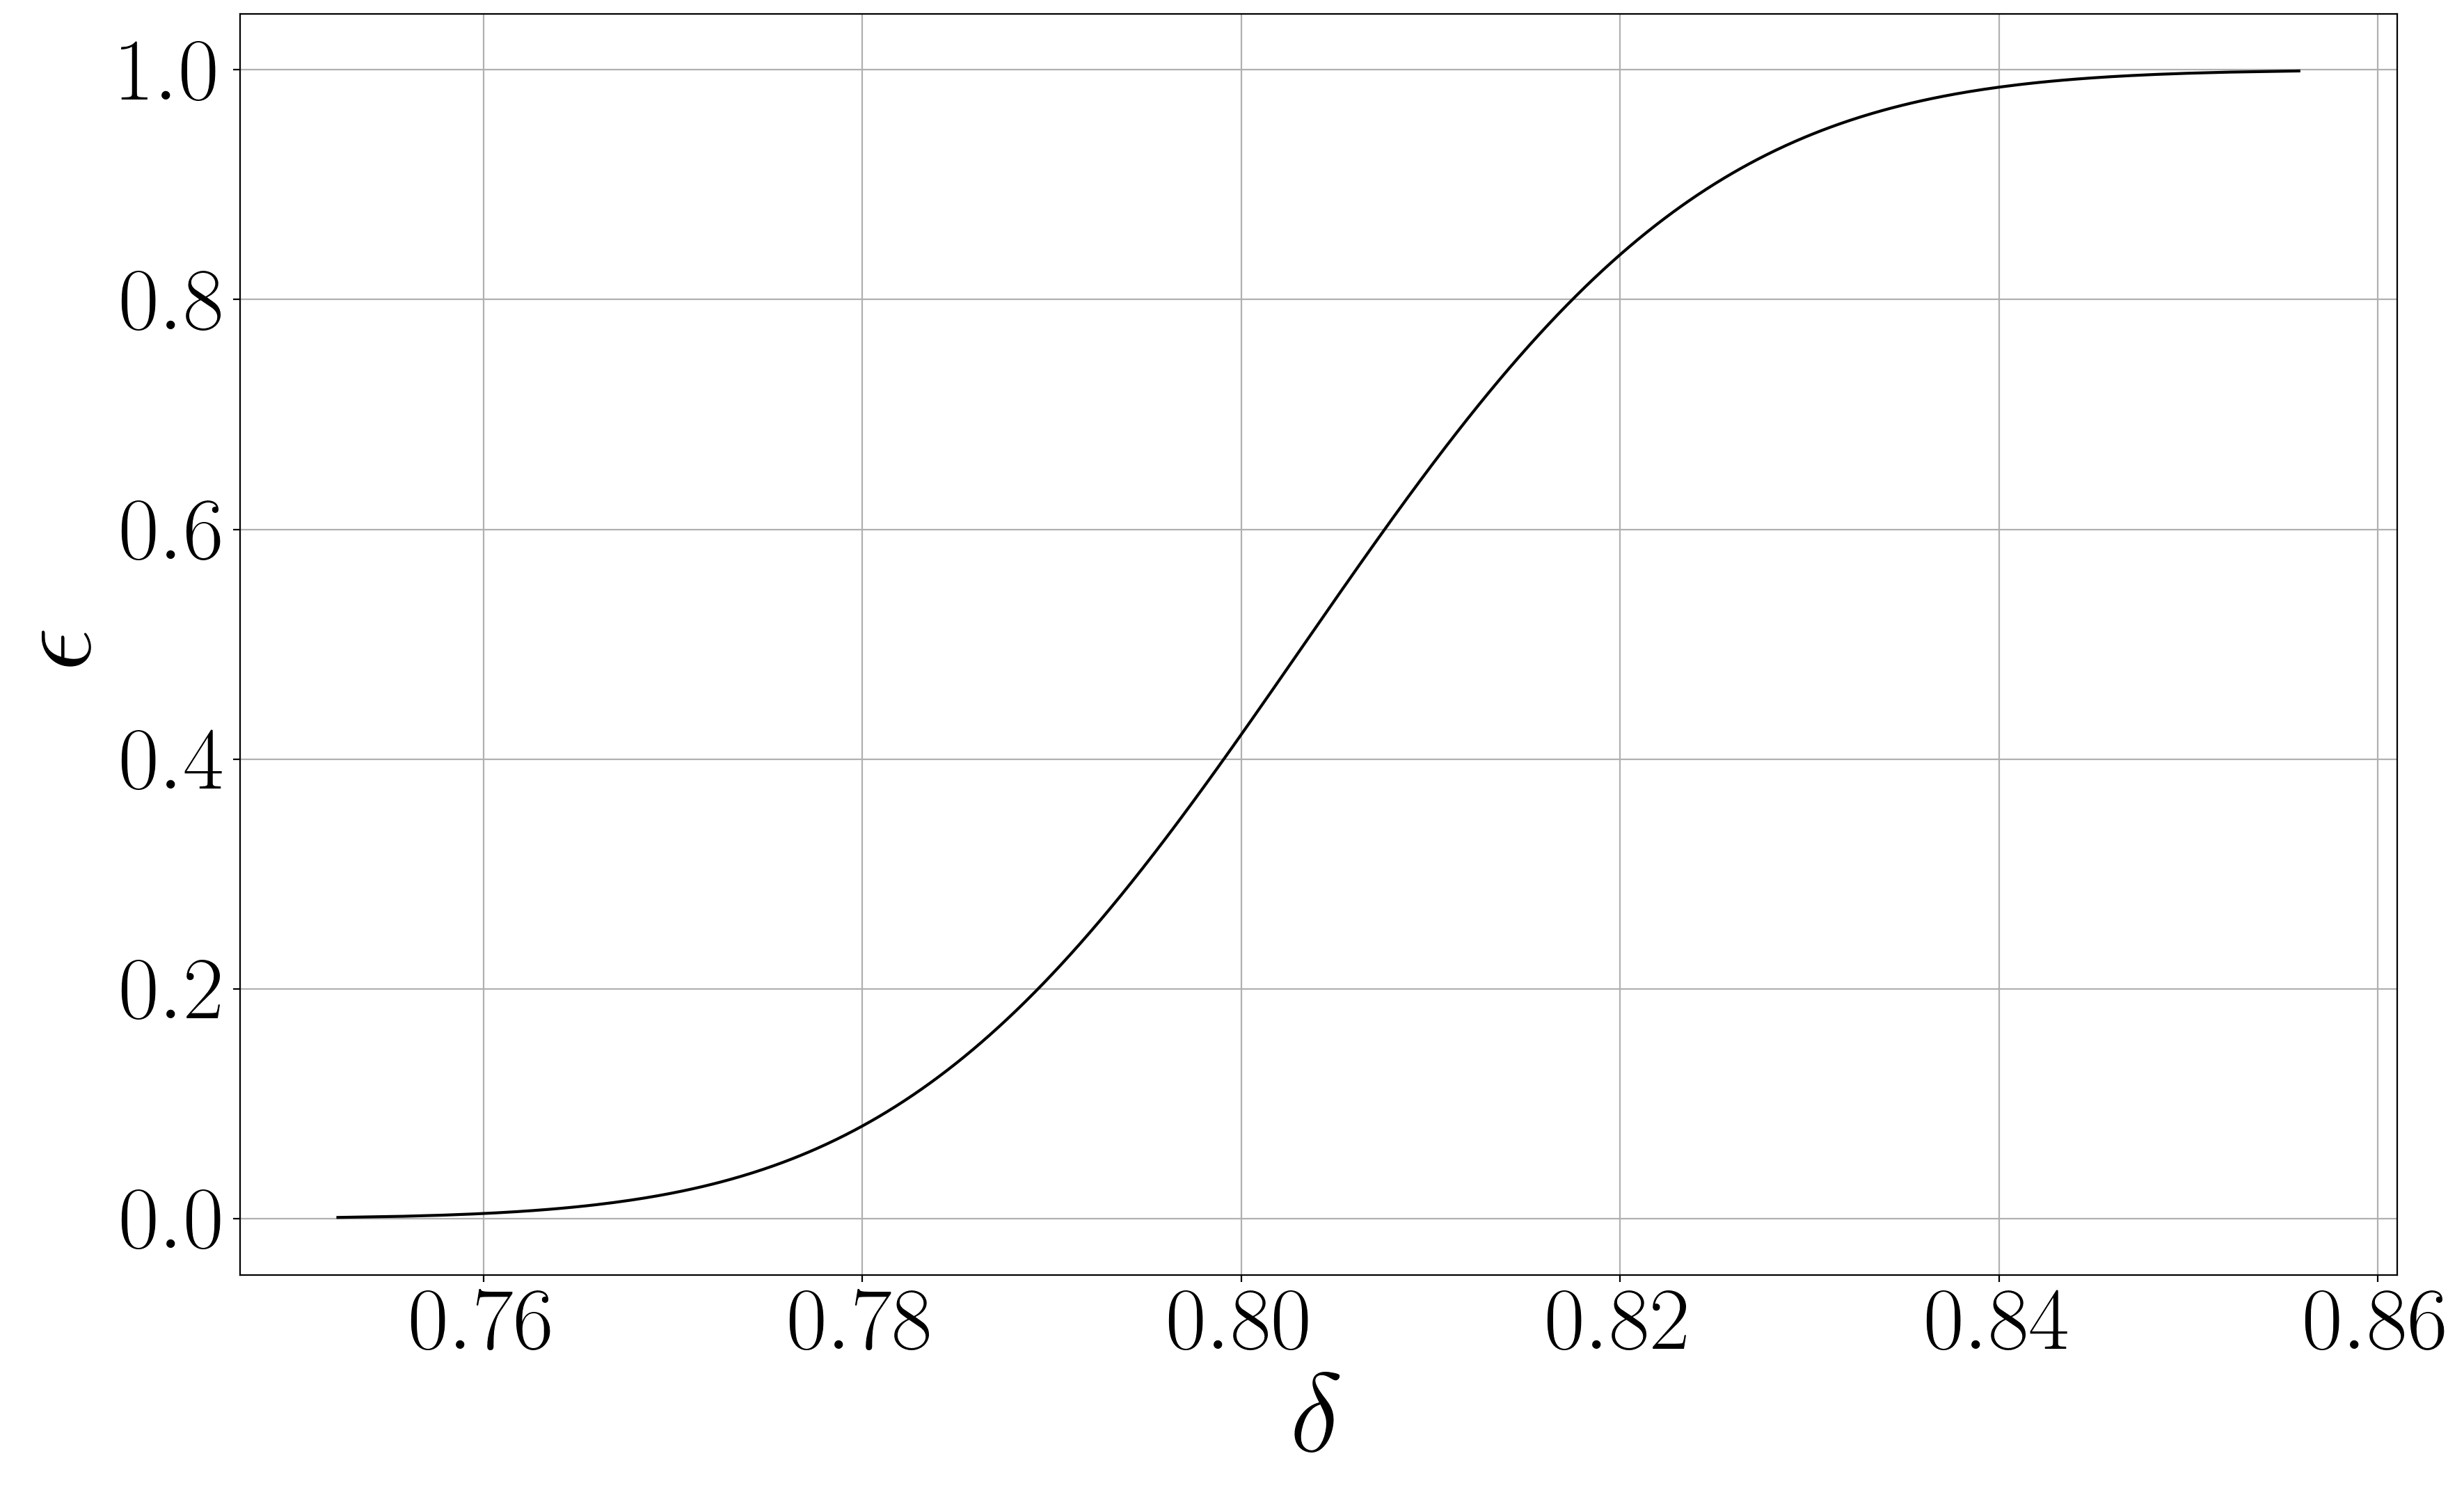

In [8]:
# delta = qp.hs_dst(rho, true_rho)
delta = qp.hs_dst(rho_mle, true_rho)

plt.figure(figsize=(20, 12), dpi=200)
plt.grid()
plt.xlabel('$\\delta$')
plt.ylabel('$\\epsilon$')
plt.plot(dist + delta, CLs, '-k')
# plt.legend()
# plt.plot([delta] * 2, [0, 1], '--g')
plt.savefig('gamma_imgs/paper_imgs/experimental_ghz4_mle.png')

## W

In [14]:
results = np.loadtxt('measurements_W.dat')
results = sort_results(results)
results.shape

(3, 1296)

In [15]:
tmg = qp.tomography.StateTomograph(get_GHZ(4))
tmg.experiment(100 * 81, 'proj')
tmg.results = np.array(convert_rbm_to_qp(torch.Tensor(results[2]))[0]) * 100
rho = tmg.point_estimate('mle', max_iter=10)
# dist = tmg.bootstrap(500, 'mle', max_iter=10)

/home/esthete/Dropbox/RQC/Tomography/quantpy/quantpy/routines.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  diag_vector = tril_matrix[np.diag_indices(tril_matrix.shape[0])].astype(float)


KeyboardInterrupt: 

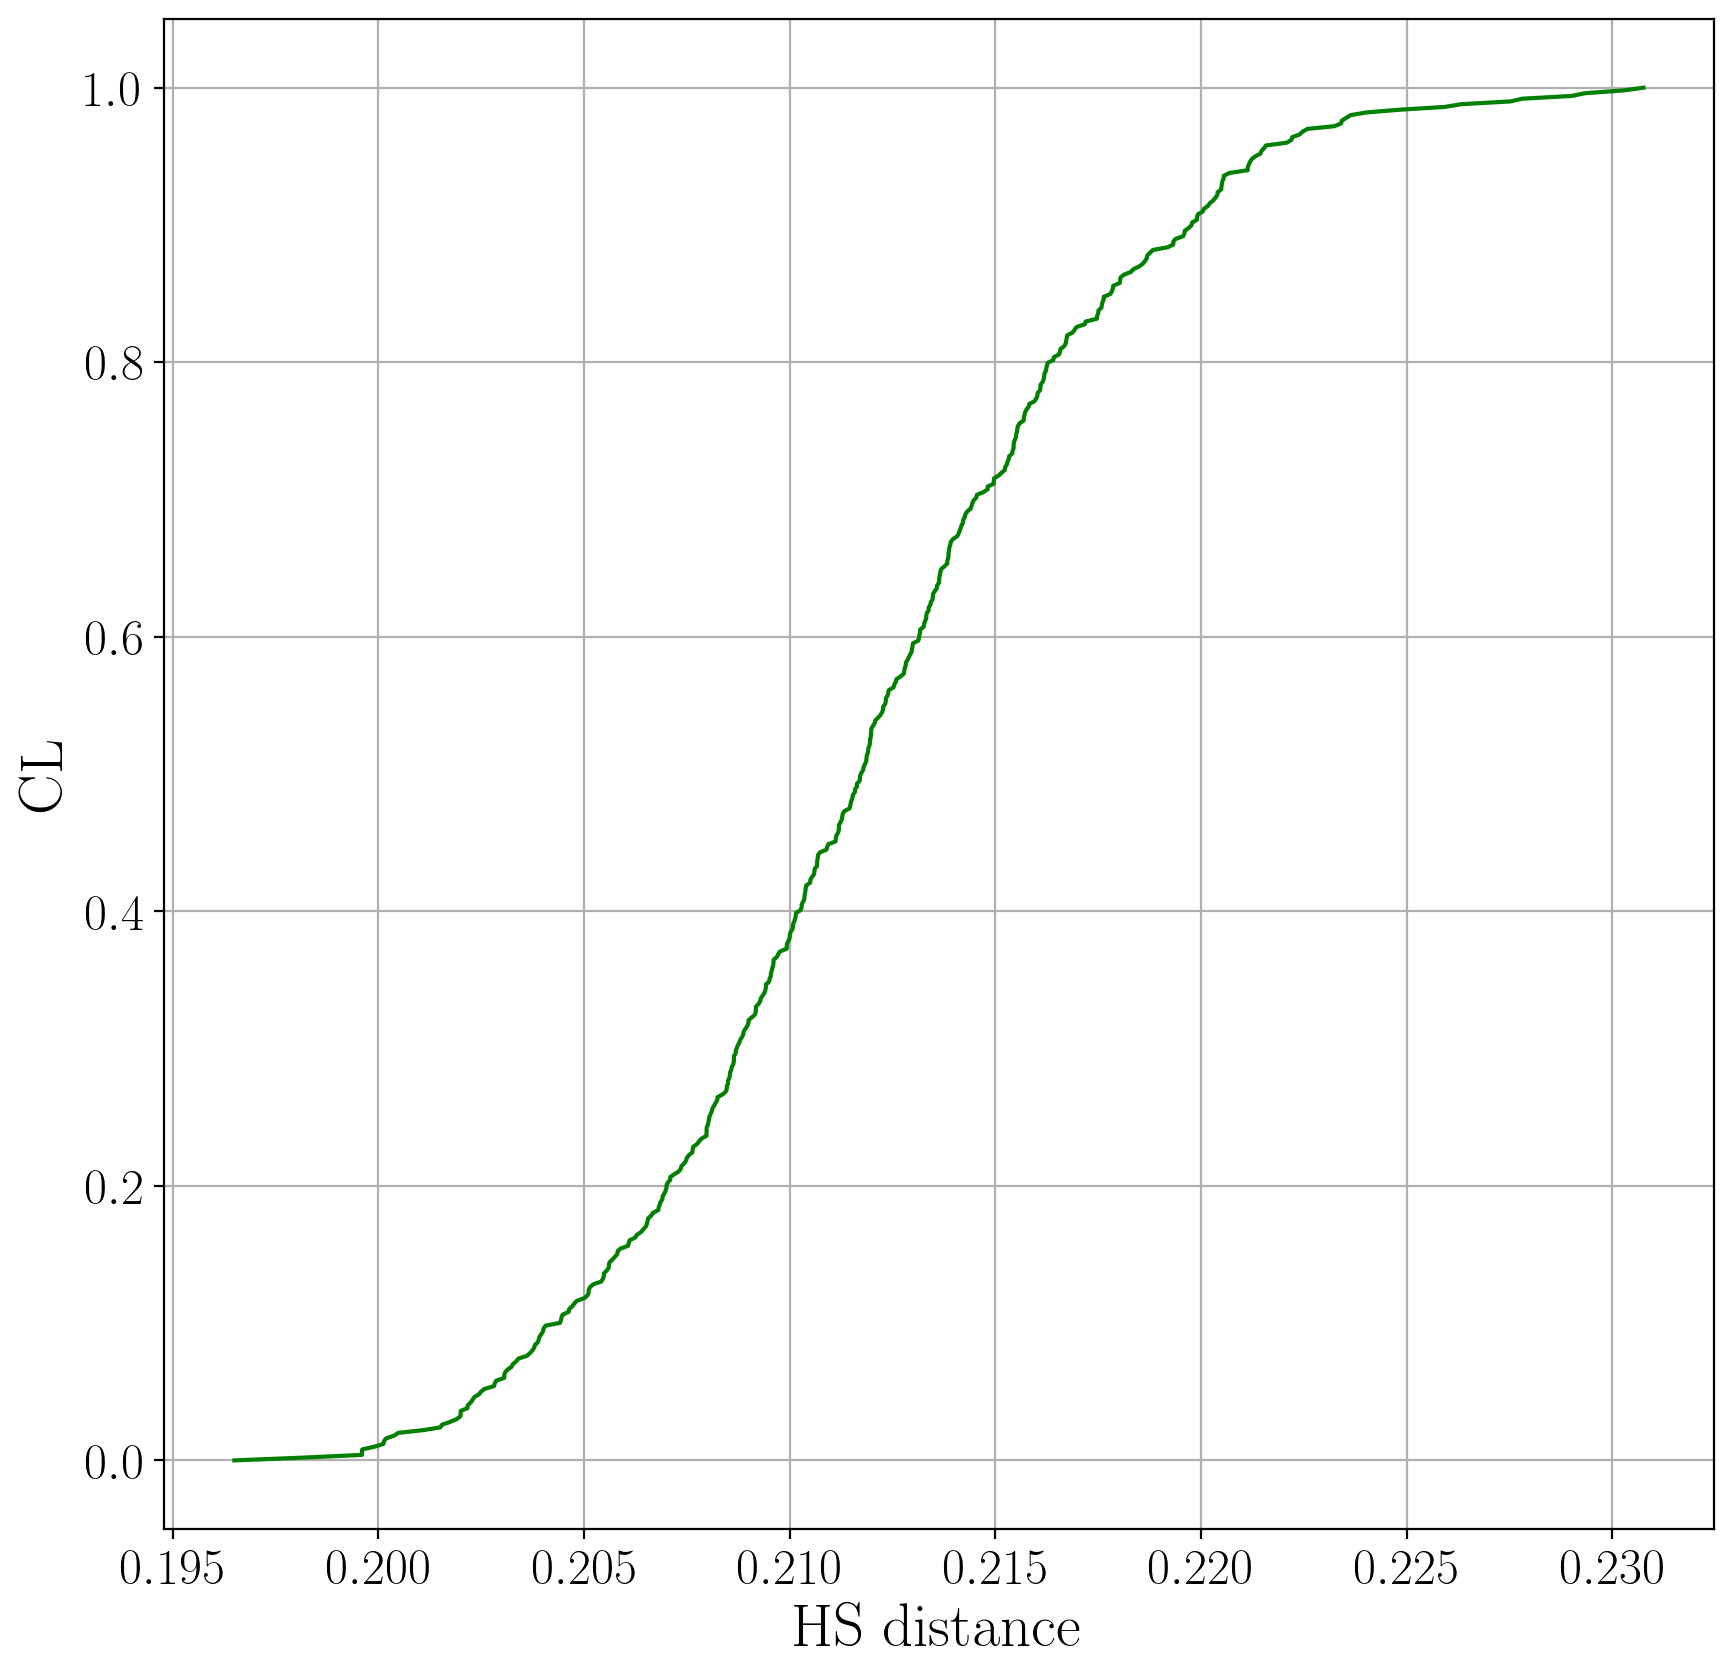

In [30]:
n_boot = 500
ket = ([0] * 7 + [1, 0, 0, 0, 1, 0, 1, 1, 0]) / np.sqrt(4)
true_rho = qp.Qobj(ket, is_ket=True)
# true_rho = get_GHZ(4)
delta = qp.hs_dst(rho, true_rho)

plt.figure(figsize=(10, 10), dpi=200)
plt.grid()
plt.xlabel('HS distance')
plt.ylabel('CL')
plt.plot(dist + delta, np.linspace(0, 1, n_boot), '-g')
# plt.plot([delta] * 2, [0, 1], '--g')
plt.savefig('imgs/w.png')

## RBM state tomo

In [24]:
def rbm_tomo(tmg, device='cpu'):
    state = tmg.state
    
    loopmodel_num = 1
    model_num = 50
    dimV = 2 * state.n_qubits
    N_qubits = state.n_qubits
    dimH = 30
    N_epochs = 1000
    batch_size = 6 ** state.n_qubits
    learning_rate = 1
    sigma = 3
    alpha = 0.99
    N_samples = 1000
    N_steps = 20
    
    n_samples = tmg.n_measurements[0]

    rbm_results = torch.zeros(3, 6 ** state.n_qubits)
    for i in range(6 ** state.n_qubits):
        rbm_results[0, i] = i // (2 ** state.n_qubits)
        rbm_results[1, i] = i % (2 ** state.n_qubits)

    rbm_results[2] = convert_qp_to_rbm(tmg.results / n_samples)

    indexes=torch.arange(4 ** state.n_qubits, dtype=torch.int32)

    f_proj = f(rbm_results,indexes,dimV,datatype,device)
    rho_rbm_raw, _, _, loss_func = rbm(rbm_results,loopmodel_num,model_num,dimV,dimH,N_epochs,batch_size,
                                       learning_rate,sigma,alpha,N_samples,N_steps,device,datatype,
                                       indexes,f_proj)

    min_ind = np.unravel_index(np.nanargmin(loss_func[:,:,-1]),(loopmodel_num,model_num))
    rho_rbm = qp.Qobj(rho_rbm_raw[min_ind[0]][min_ind[1]])
    return rho_rbm

In [25]:
def count_idfr(CL_list):
    reference = np.linspace(0, 1, len(CL_list))
    return np.sum(np.abs(CL_list - reference)) / len(CL_list)

In [26]:
def get_CL_list_state(state, n_boot=1000, n_iter=1000):
    CL_list = []
    
    for _ in tqdm(range(n_iter)):
        tmg = qp.StateTomograph(state)
        tmg.experiment(1000)
        rho_est = qp.tomography.state._make_feasible(rbm_tomo(tmg))
        delta = qp.hs_dst(rho_est, state)
        dist = tmg.bootstrap(n_boot, use_new_estimate=True, state=rho_est)
        in_ci = np.where(delta > dist)[0]
        if len(in_ci) == 0:
            CL_list.append(0)
        else:
            CL_list.append(in_ci[-1] / n_boot)
    
    return CL_list

In [27]:
state = qp.Qobj([1, 0], is_ket=True)
CL_list = get_CL_list_state(state, n_iter=100)
CL_list = np.array(sorted(CL_list))
np.save('zero_rbm_n_iter=100.npy', CL_list)

KeyboardInterrupt: 

In [23]:
state = get_GHZ(2)
CL_list = get_CL_list_state(state, n_iter=100)
CL_list = np.array(sorted(CL_list))
np.save('ghz2_rbm_n_iter=100.npy', CL_list)

/home/esthete/Dropbox/RQC/pgptomography/Lib/Mixed_multimodel_exaustive.py:193: RuntimeWarning: invalid value encountered in multiply
  state = ampl*np.exp(1j*phase/2.)
/home/esthete/Dropbox/RQC/pgptomography/Lib/Mixed_multimodel_exaustive.py:193: RuntimeWarning: invalid value encountered in true_divide
  state = ampl*np.exp(1j*phase/2.)


In [52]:
state = qp.qobj.fully_mixed(1)
CL_list = get_CL_list_state(state, n_iter=1000)
CL_list = np.array(sorted(CL_list))
np.save('fullymixed_rbm_n_iter=1000.npy', CL_list)

In [53]:
state = qp.Qobj([np.cos(np.pi/8), np.sin(np.pi/8) * np.exp(1j*np.pi/4)], is_ket=True)
CL_list = get_CL_list_state(state, n_iter=1000)
CL_list = np.array(sorted(CL_list))
np.save('pure_rbm_n_iter=1000.npy', CL_list)

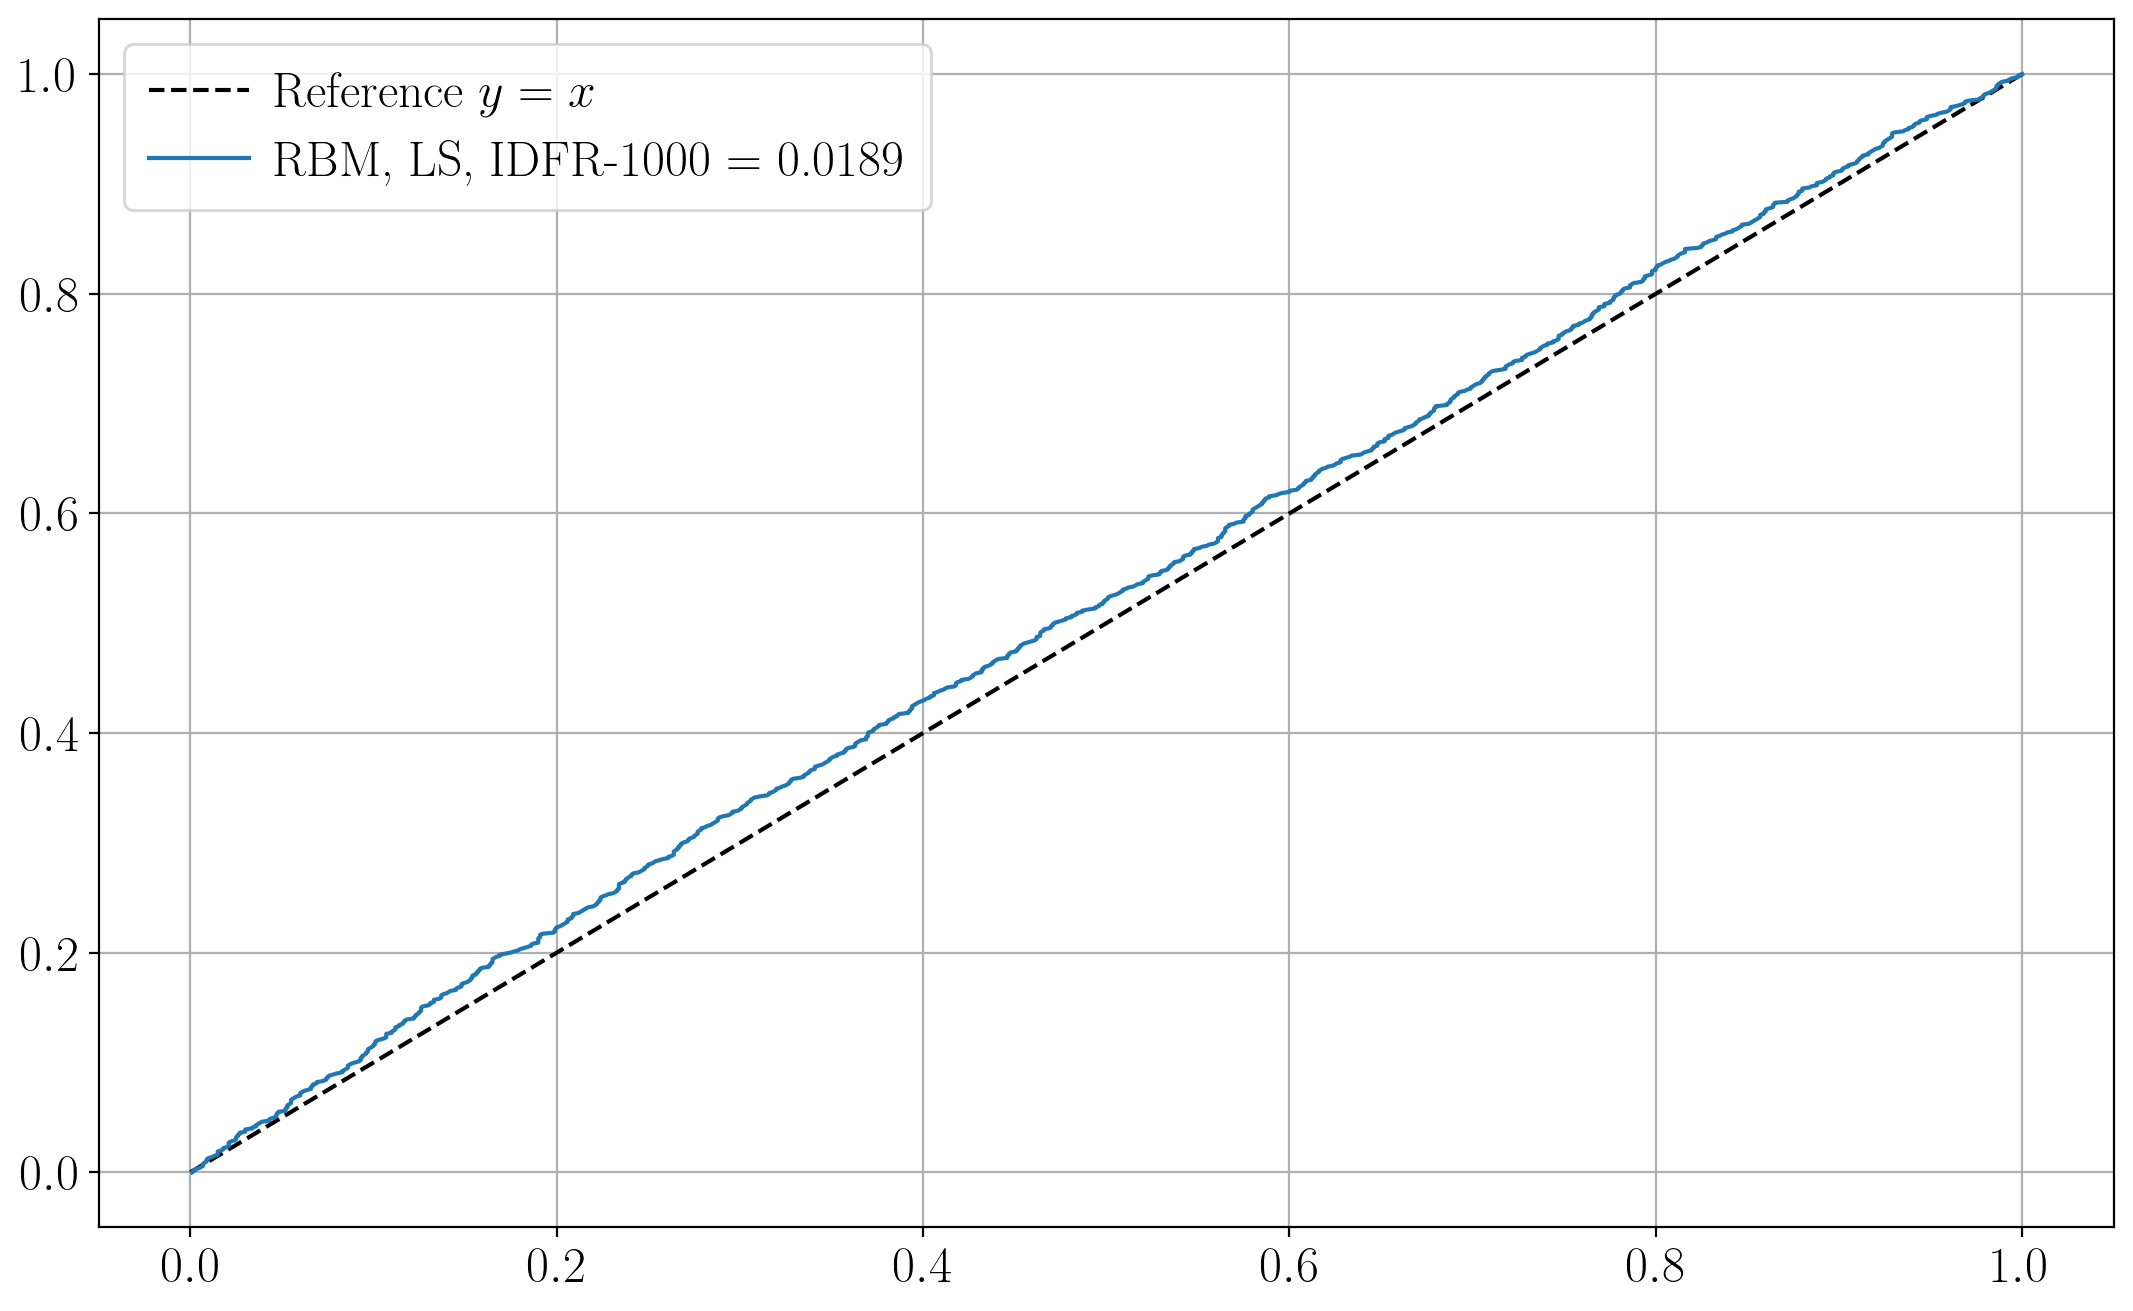

In [54]:
n_iter = 1000
n_boot = 10 ** 3

plt.figure(dpi=200, figsize=(13, 8))
plt.grid()
plt.plot(np.linspace(0, 1, n_iter + 1), np.linspace(0, 1, n_iter + 1), '--k', label='Reference $y=x$')
plt.plot(CL_list, np.linspace(0, 1, n_iter), label='RBM, LS, IDFR-{} = {:.4f}'.format(n_iter, count_idfr(CL_list)) )
plt.legend()
plt.show()

## RBM process tomo

In [55]:
class RbmProcessTomograph(qp.ProcessTomograph):
    def _point_estimate_states(self, cptp, method, physical, init):
        if method == 'rbm':
            output_states = [rbm_tomo(tmg) for tmg in self.tomographs]
        else:
            output_states = [tmg.point_estimate(method, physical, init) for tmg in self.tomographs]
        output_basis = qp.basis.Basis(output_states)
        choi_matrix = qp.Qobj(np.zeros((output_basis.dim, output_basis.dim)))
        for decomposed_single_entry in self._decomposed_single_entries:
            single_entry = self.input_basis.compose(decomposed_single_entry)
            transformed_single_entry = output_basis.compose(decomposed_single_entry)
            choi_matrix += qp.routines.kron(single_entry, transformed_single_entry)
        self.reconstructed_channel = qp.Channel(choi_matrix)
        if cptp and not self.reconstructed_channel.is_cptp(verbose=False):
            self.reconstructed_channel = self.cptp_projection(self.reconstructed_channel)
        return self.reconstructed_channel

In [13]:
class RbmStateTomograph(qp.StateTomograph):
    def point_estimate(self, method='lin', physical=True, init='lin', max_iter=100, tol=1e-3):
        if method == 'lin':
            self.reconstructed_state = self._point_estimate_lin(physical=physical)
        elif method == 'mle':
            self.reconstructed_state = self._point_estimate_mle_chol(init=init, max_iter=max_iter, tol=tol)
        elif method == 'mle-constr':
            self.reconstructed_state = self._point_estimate_mle_chol_constr(init=init, max_iter=max_iter, tol=tol)
        elif method == 'mle-bloch':
            self.reconstructed_state = self._point_estimate_mle_bloch(physical=physical)
        elif method == 'rbm':
            self.reconstructed_state = qp.tomography.state._make_feasible(rbm_tomo(self))
        else:
            raise ValueError('Invalid value for argument `method`')
        return self.reconstructed_state

In [14]:
def get_CL_list_channel(channel, n_boot=1000, n_iter=100, input_impurity=0.05):
    CL_list = []
    
    for _ in tqdm(range(n_iter)):
        tmg = RbmProcessTomograph(channel, input_impurity=input_impurity)
        tmg.experiment(1000)
        chan_est = tmg.point_estimate(method='states', states_est_method='rbm')
        delta = qp.hs_dst(chan_est.choi, channel.choi)
        dist = tmg.bootstrap(1000, use_new_estimate=True, channel=chan_est)
        CL_list.append(np.where(delta > dist)[0][-1] / n_boot)
    
    return CL_list

In [15]:
def count_idfr(CL_list):
    reference = np.linspace(0, 1, len(CL_list))
    return np.sum(np.abs(CL_list - reference)) / len(CL_list)

In [24]:
channel = qp.operator.H.as_channel()
CL_list = get_CL_list_channel(channel, input_impurity=0.01)
CL_list = np.array(sorted(CL_list))

In [16]:
name2title = {
    'hadamard': 'Hadamard gate',
    'fully-mixed': 'Fully mixed state',
    'zero': '$\\left|0\\right\\rangle$',
    'pure': '$\\cos{\\frac{\\pi}{8}}\\left|0\\right\\rangle + \\sin{\\frac{\\pi}{8}}e^{\\frac{i\\pi}{4}}\\left|1\\right\\rangle$',
    'fully-dep': 'Fully depolarizing channel',
    'cnot': 'CNOT gate',
    'ghz2': 'GHZ state, 2 qubits',
    'ghz3': 'GHZ state, 3 qubits',
}

In [17]:
def plot_ci_state(state, name):
    tmg = RbmStateTomograph(state)
    tmg.experiment(1000)
    
    state_rbm = tmg.point_estimate(method='rbm')
    state_lin = tmg.point_estimate(method='lin')
    state_mle = tmg.point_estimate(method='mle')
    
    dist = dict()
    
    dist[('RBM', 'LS')] = tmg.bootstrap(1000, est_method='lin', use_new_estimate=True, state=state_rbm)
    dist[('LS', 'LS')] = tmg.bootstrap(1000, est_method='lin', use_new_estimate=True, state=state_lin)
    dist[('LS', 'MLE')] = tmg.bootstrap(1000, est_method='mle', use_new_estimate=True, state=state_lin)
    dist[('MLE', 'LS')] = tmg.bootstrap(1000, est_method='lin', use_new_estimate=True, state=state_mle)
    dist[('MLE', 'MLE')] = tmg.bootstrap(1000, est_method='mle', use_new_estimate=True, state=state_mle)
    
    with open('tomo_results/intervals/{}.pkl'.format(name), 'wb') as file:
        pickle.dump(dist, file)
    
    CL = np.linspace(0, 1, len(dist[('RBM', 'LS')]))
    plt.figure(dpi=200, figsize=(12, 13))
    for key, res in dist.items():
        plt.plot(res, CL, label=', '.join(key))
    plt.xlabel('$\\delta$')
    plt.ylabel('$\\epsilon$')
    plt.title(name2title[name])
    plt.grid()
    plt.legend()
    plt.savefig('tomo_imgs/intervals/{}.png'.format(name))

/home/esthete/Dropbox/RQC/pgptomography/Lib/quantpy/quantpy/routines.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  diag_vector = tril_matrix[np.diag_indices(tril_matrix.shape[0])].astype(float)


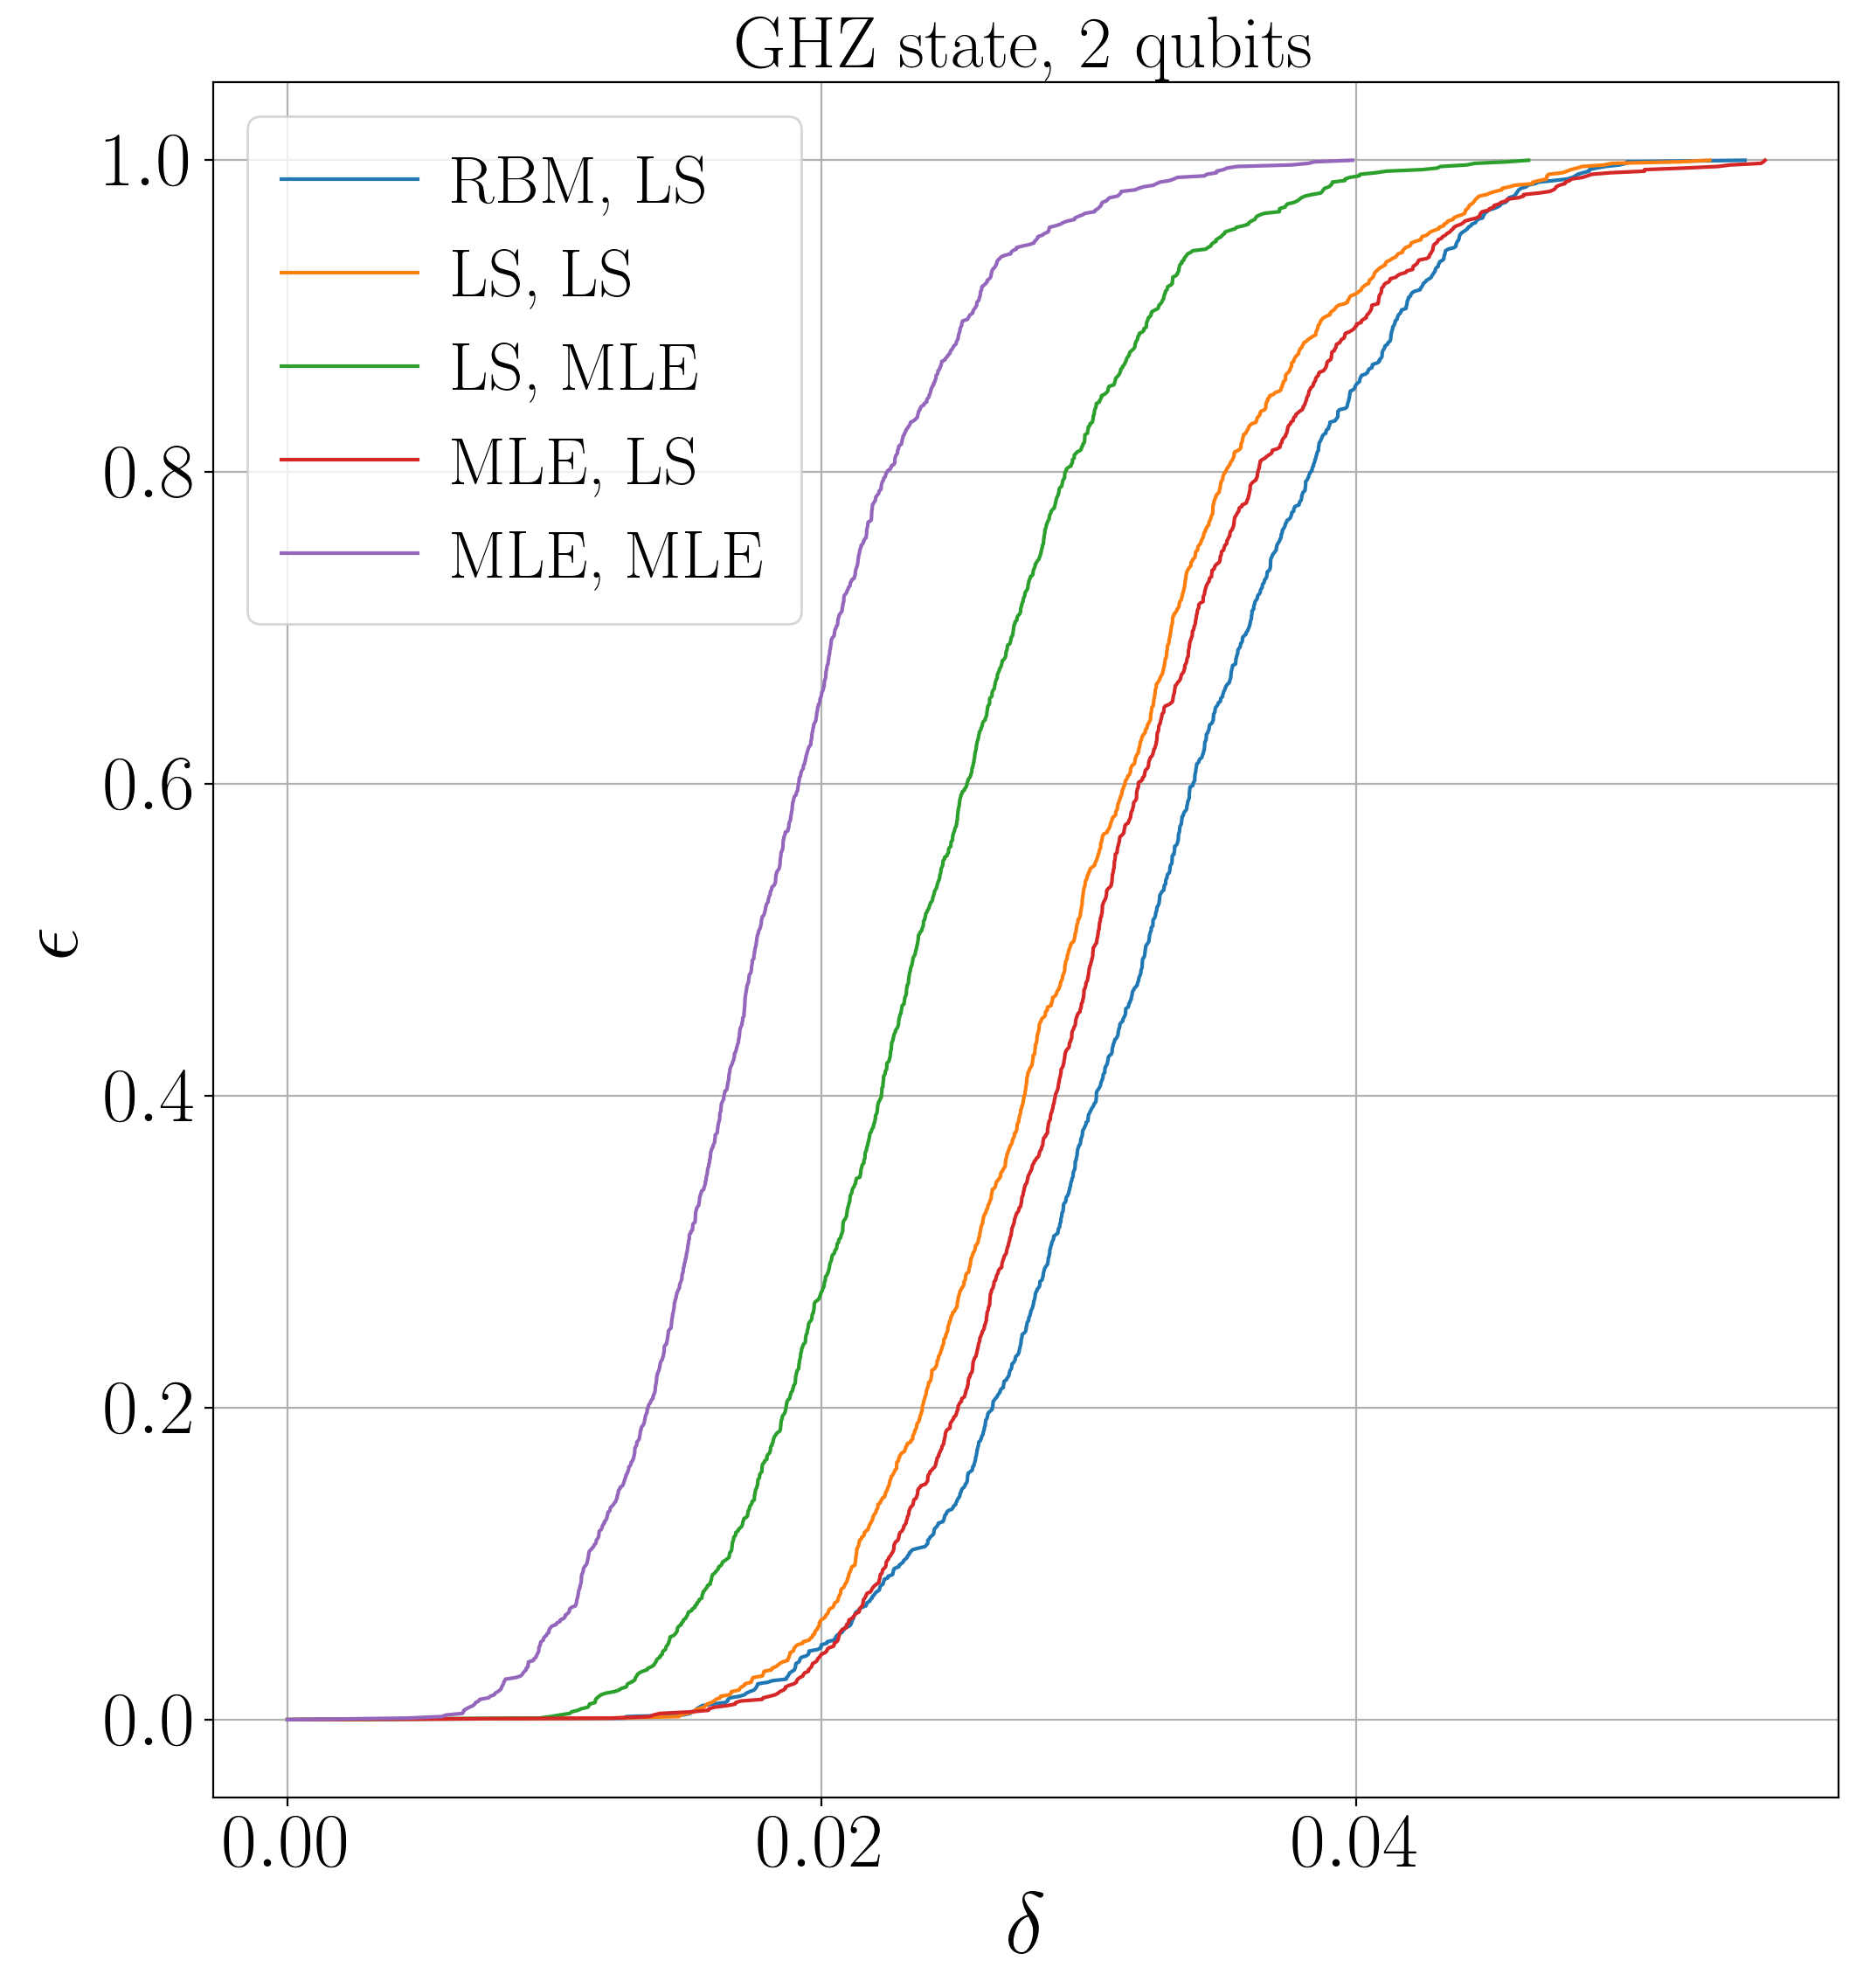

In [18]:
state = get_GHZ(2)
name = 'ghz2'
plot_ci_state(state, name)

/home/esthete/Dropbox/RQC/pgptomography/Lib/Mixed_multimodel_exaustive.py:193: RuntimeWarning: invalid value encountered in multiply
  state = ampl*np.exp(1j*phase/2.)
/home/esthete/Dropbox/RQC/pgptomography/Lib/Mixed_multimodel_exaustive.py:193: RuntimeWarning: invalid value encountered in true_divide
  state = ampl*np.exp(1j*phase/2.)
/home/esthete/Dropbox/RQC/pgptomography/Lib/quantpy/quantpy/routines.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  diag_vector = tril_matrix[np.diag_indices(tril_matrix.shape[0])].astype(float)


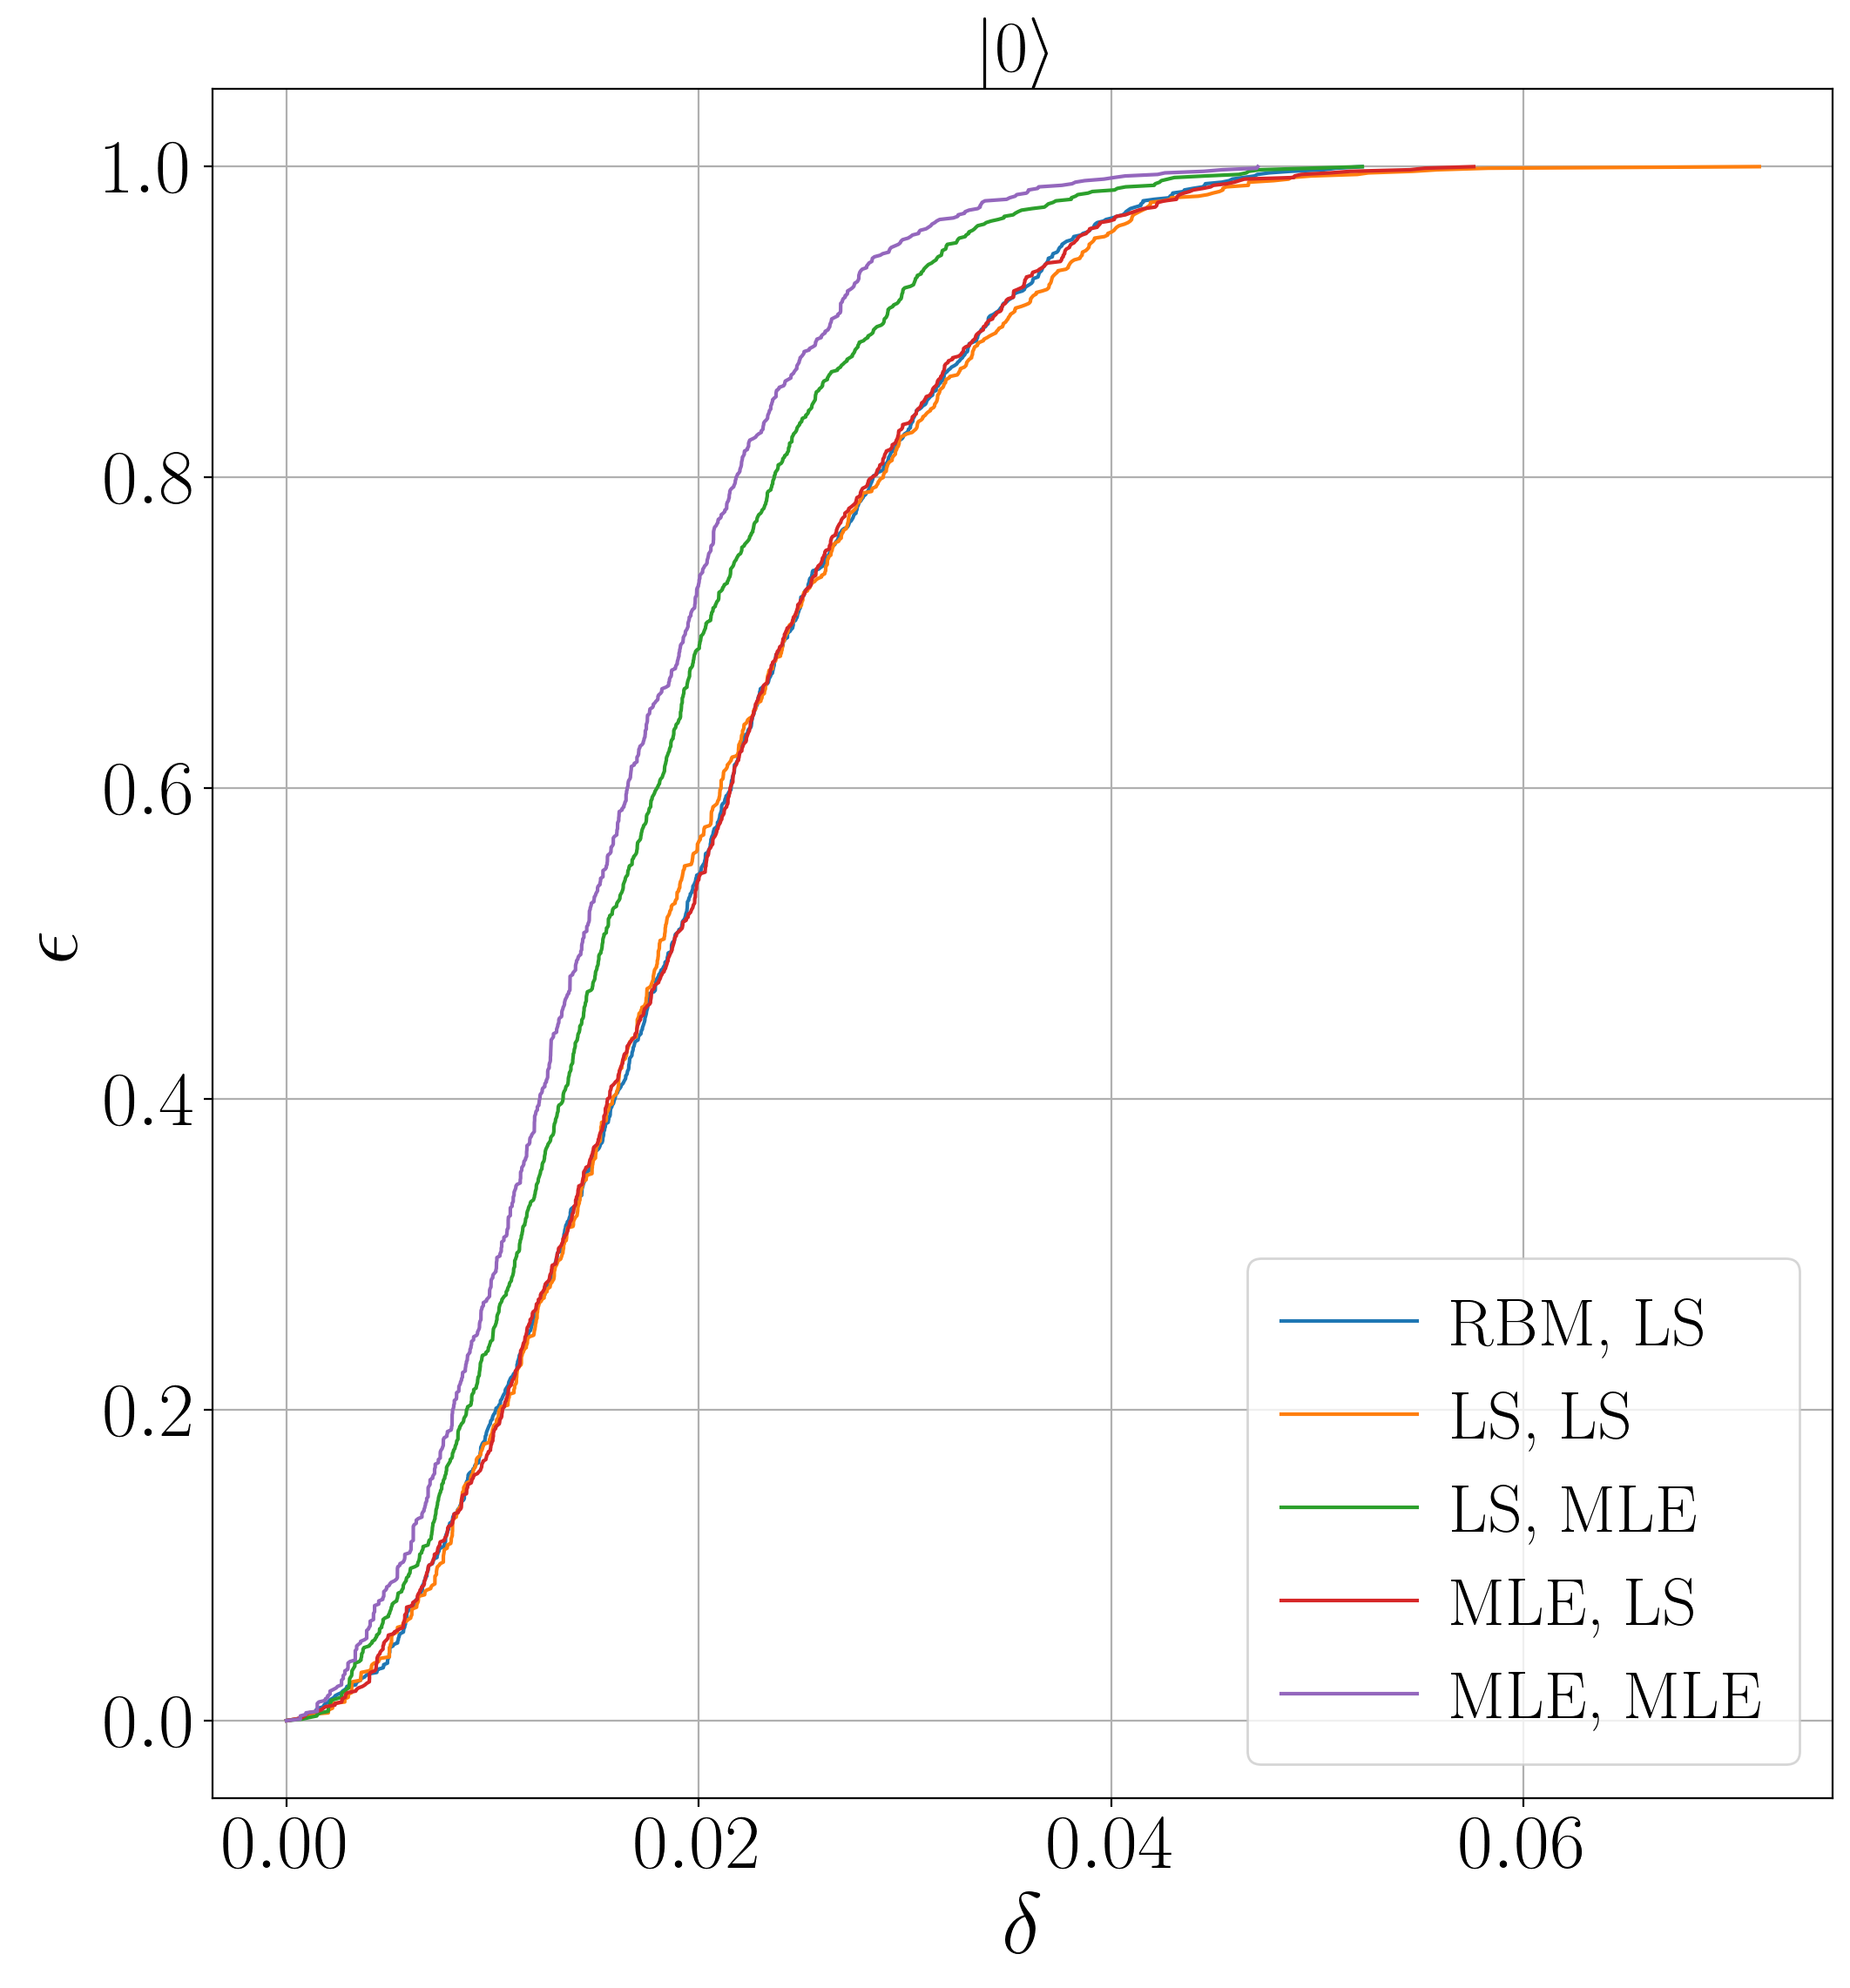

In [19]:
state = qp.Qobj([1, 0], is_ket=True)
name = 'zero'
plot_ci_state(state, name)

/home/esthete/Dropbox/RQC/pgptomography/Lib/Mixed_multimodel_exaustive.py:193: RuntimeWarning: invalid value encountered in multiply
  state = ampl*np.exp(1j*phase/2.)
/home/esthete/Dropbox/RQC/pgptomography/Lib/Mixed_multimodel_exaustive.py:193: RuntimeWarning: invalid value encountered in true_divide
  state = ampl*np.exp(1j*phase/2.)
/home/esthete/Dropbox/RQC/pgptomography/Lib/quantpy/quantpy/routines.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  diag_vector = tril_matrix[np.diag_indices(tril_matrix.shape[0])].astype(float)


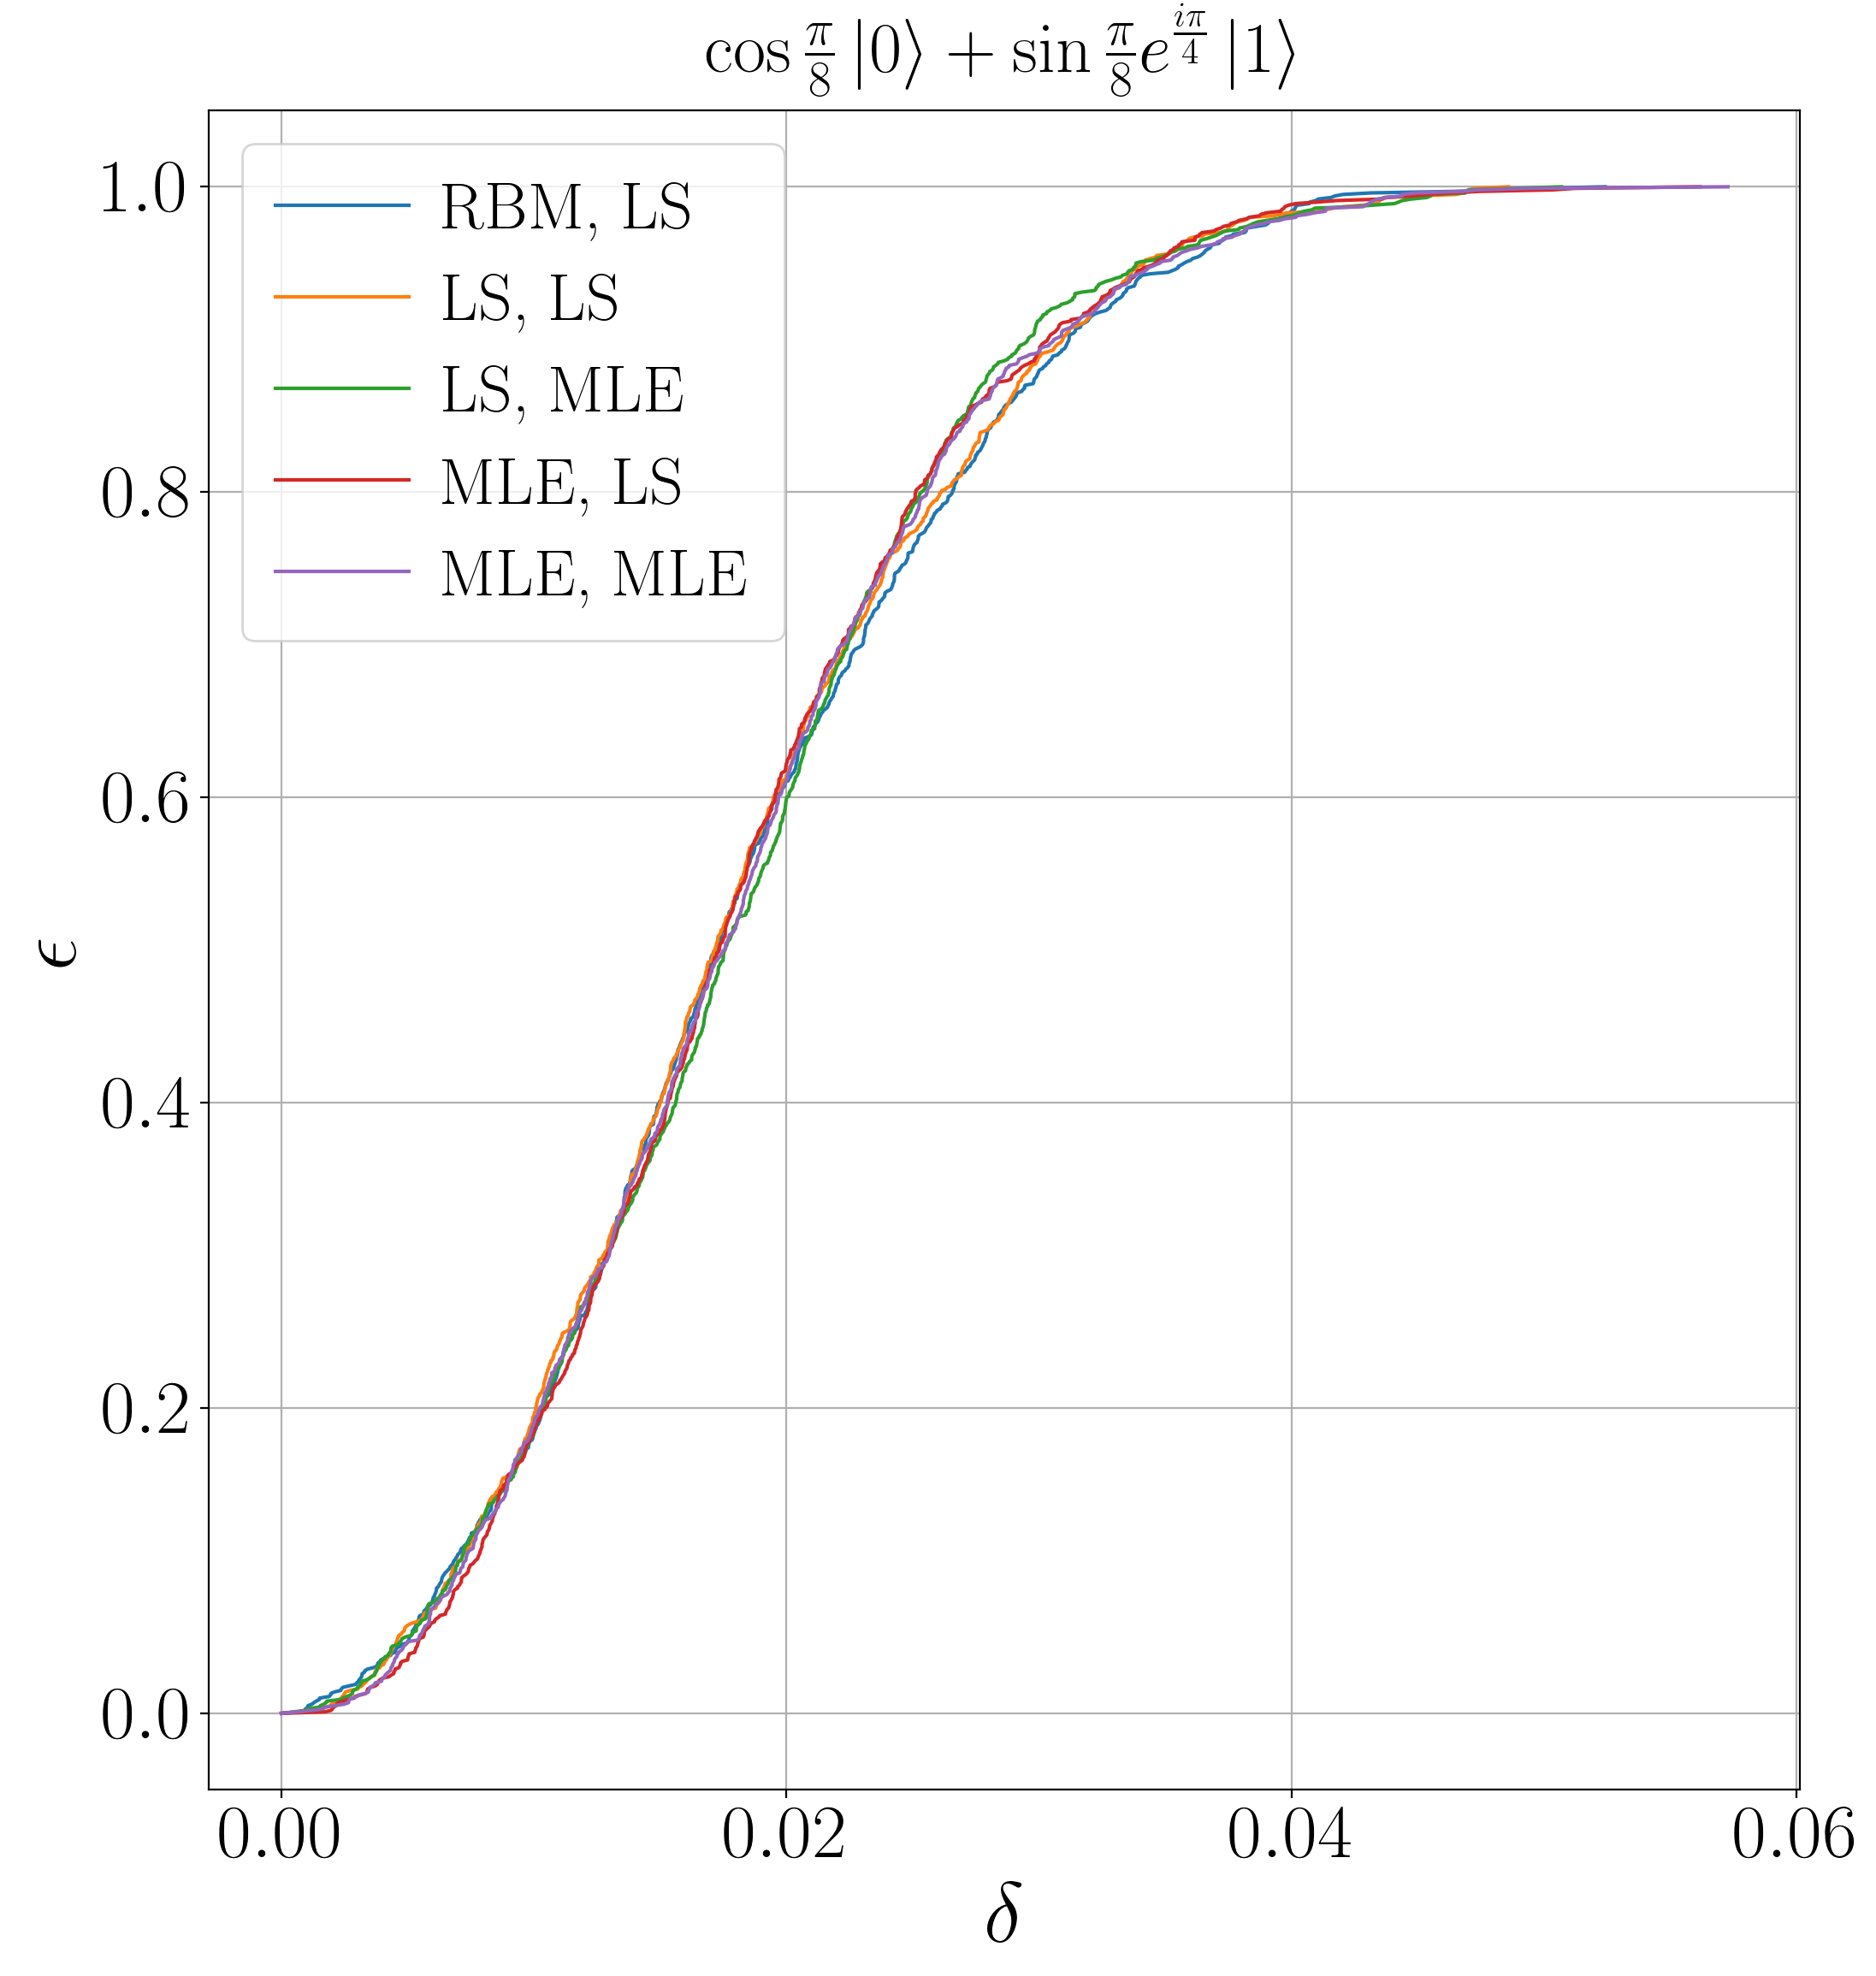

In [104]:
state = qp.Qobj([np.cos(np.pi / 8), np.sin(np.pi / 8) * np.exp(np.pi * 1j / 4)], is_ket=True)
name = 'pure'
plot_ci_state(state, name)

/home/esthete/Dropbox/RQC/pgptomography/Lib/Mixed_multimodel_exaustive.py:193: RuntimeWarning: invalid value encountered in multiply
  state = ampl*np.exp(1j*phase/2.)
/home/esthete/Dropbox/RQC/pgptomography/Lib/Mixed_multimodel_exaustive.py:193: RuntimeWarning: invalid value encountered in true_divide
  state = ampl*np.exp(1j*phase/2.)
/home/esthete/Dropbox/RQC/pgptomography/Lib/quantpy/quantpy/routines.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  diag_vector = tril_matrix[np.diag_indices(tril_matrix.shape[0])].astype(float)


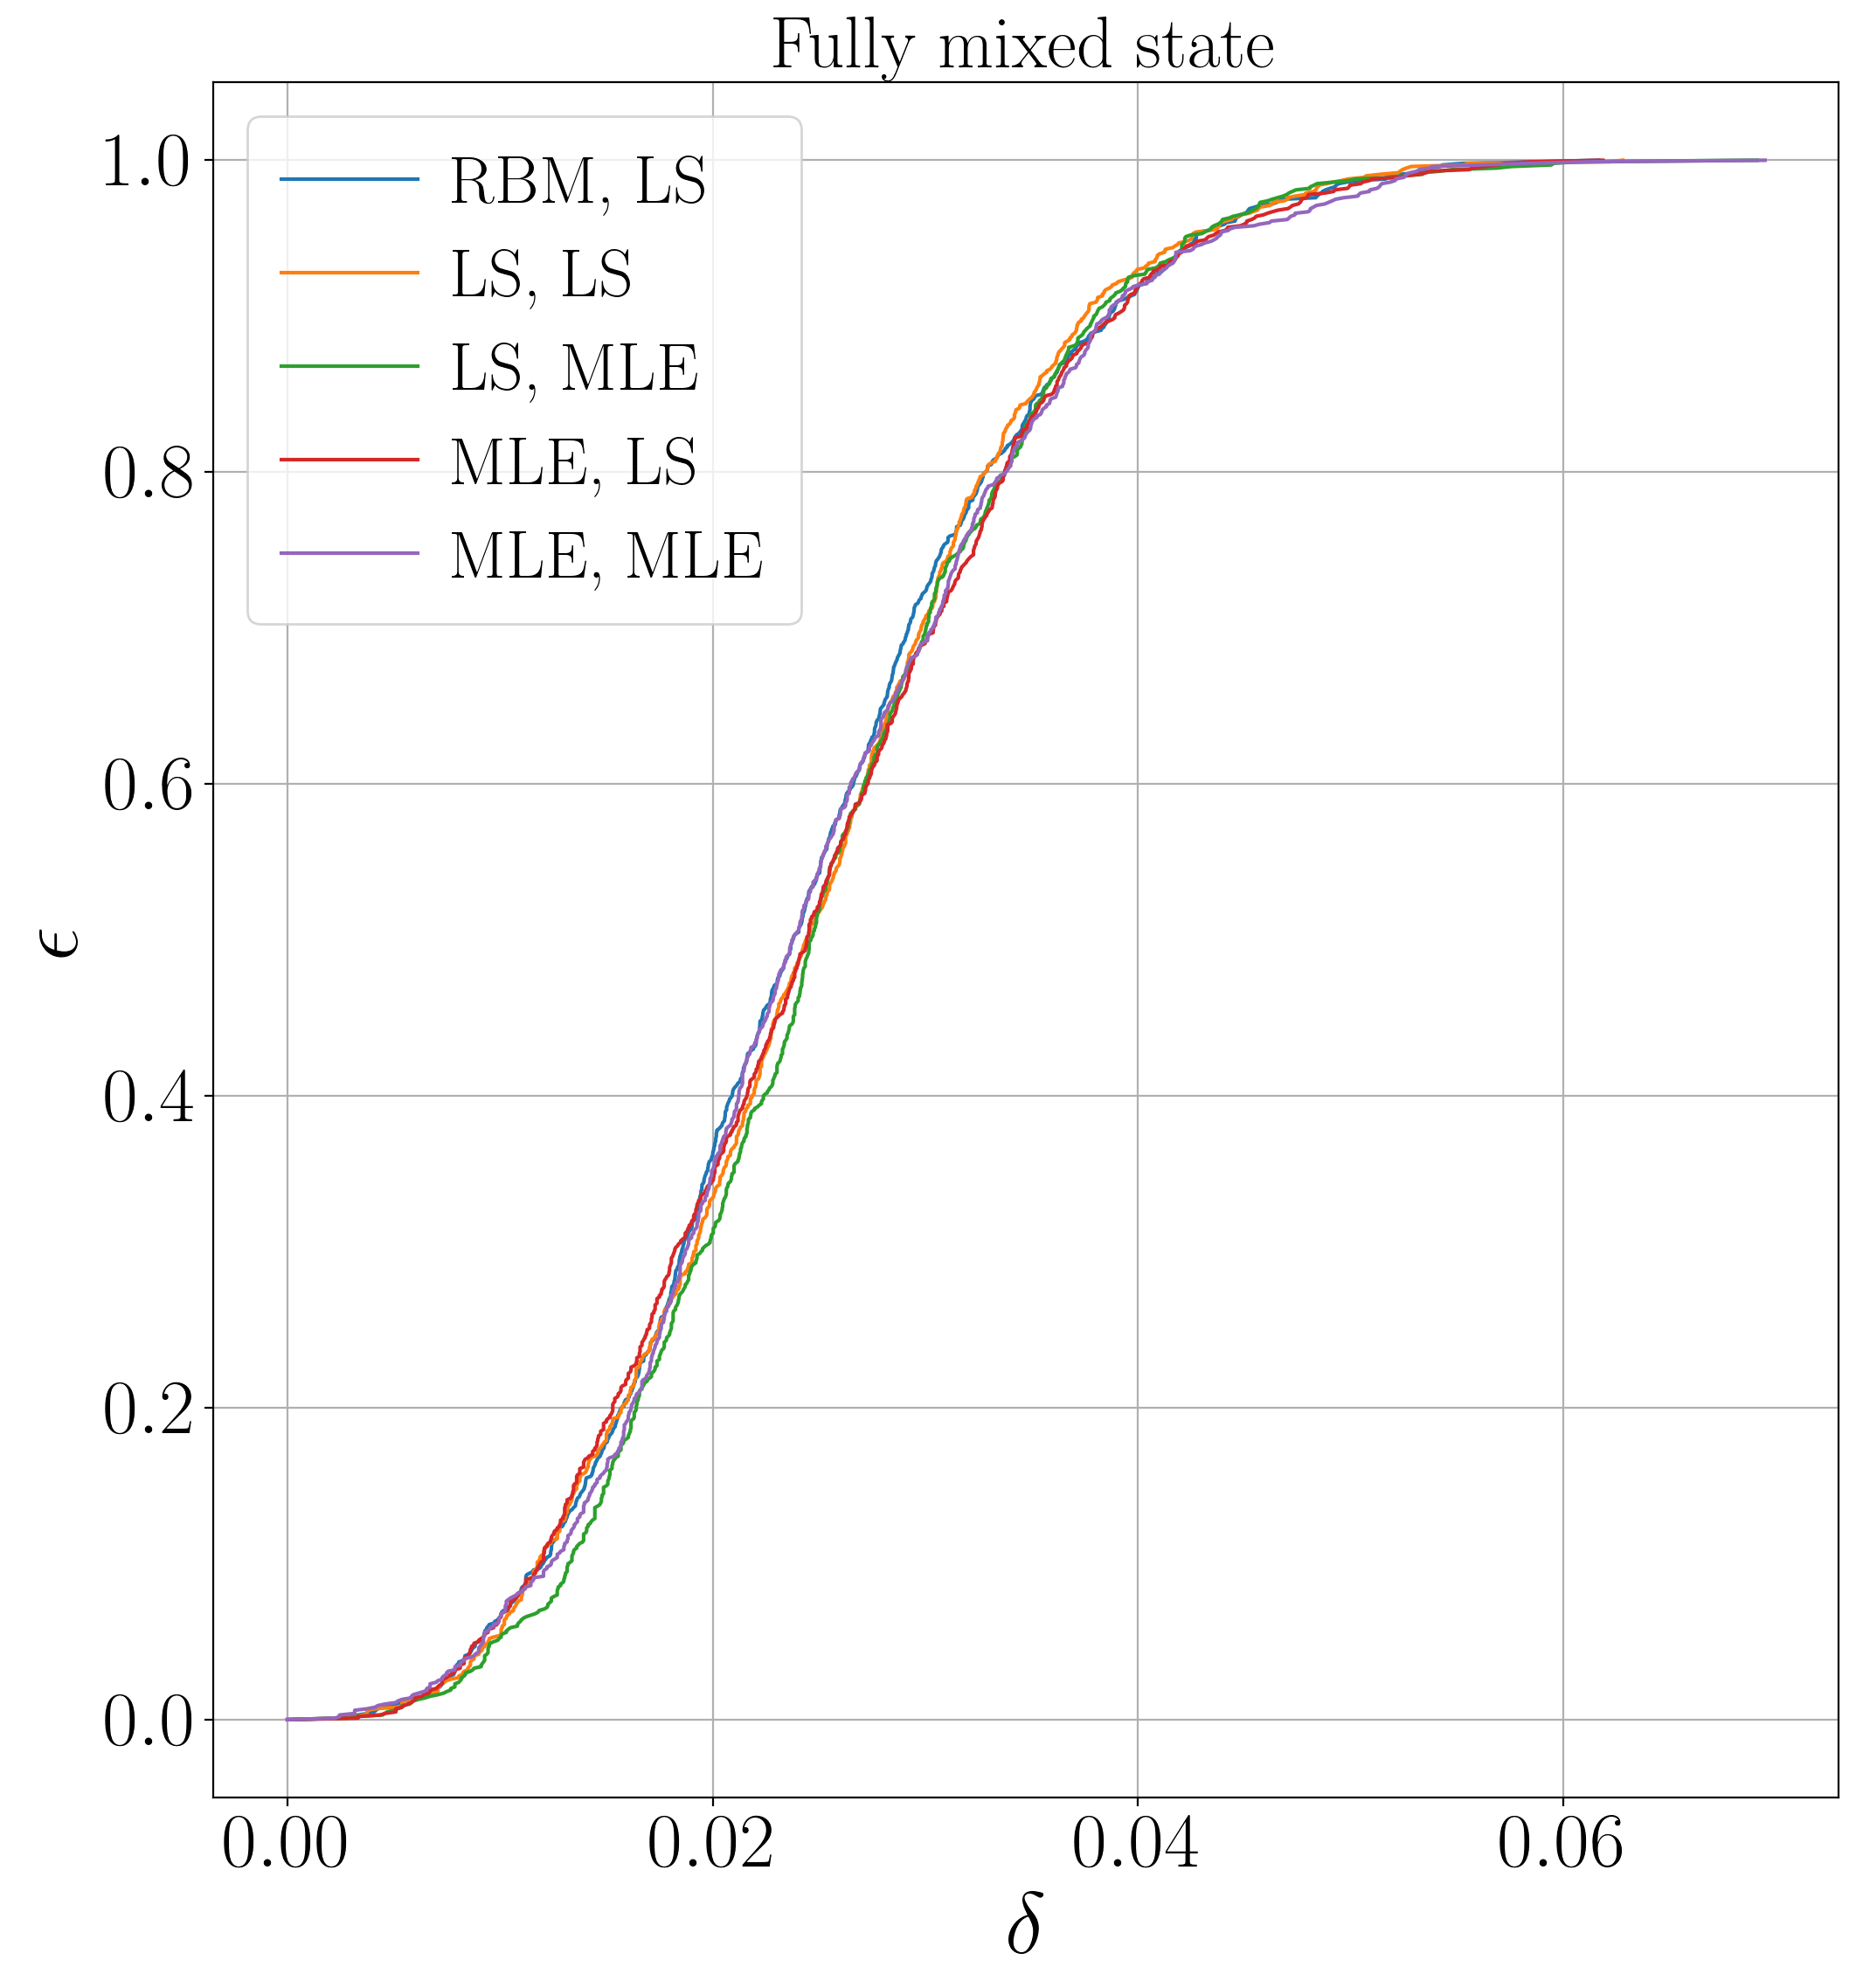

In [101]:
state = qp.qobj.fully_mixed(1)
name = 'fully-mixed'
plot_ci_state(state, name)

In [85]:
def plot_ci_channel(channel, name, p):
    tmg = RbmProcessTomograph(channel, input_impurity=p)
    tmg.experiment(1000)
    
    chan_rbm = tmg.point_estimate(method='states', states_est_method='rbm')
    chan_lin = tmg.point_estimate(method='states', states_est_method='lin')
    chan_mle = tmg.point_estimate(method='states', states_est_method='mle')
    
    dist = dict()
    
    dist[('RBM', 'LS')] = tmg.bootstrap(1000, states_est_method='lin', method='states',
                                        use_new_estimate=True, channel=chan_rbm)
    dist[('LS', 'LS')] = tmg.bootstrap(1000, states_est_method='lin', method='states',
                                       use_new_estimate=True, channel=chan_lin)
    print('dsfs')
    dist[('LS', 'MLE')] = tmg.bootstrap(1000, states_est_method='mle', method='states',
                                        use_new_estimate=True, channel=chan_lin)
    print('sdfsd')
    dist[('MLE', 'LS')] = tmg.bootstrap(1000, states_est_method='lin', method='states',
                                        use_new_estimate=True, channel=chan_mle)
    print('asdas')
    dist[('MLE', 'MLE')] = tmg.bootstrap(1000, states_est_method='mle', method='states',
                                         use_new_estimate=True, channel=chan_mle)
    
    with open('tomo_results/intervals/{}_dep={}.pkl'.format(name, p), 'wb') as file:
        pickle.dump(dist, file)
    
    CL = np.linspace(0, 1, len(dist[('MLE', 'MLE')]))
    plt.figure(dpi=200, figsize=(12, 13))
    for key, res in dist.items():
        plt.plot(res, CL, label=', '.join(key))
    plt.xlabel('$\\delta$')
    plt.ylabel('$\\epsilon$')
    plt.title(name2title[name])
    plt.grid()
    plt.legend()
    plt.savefig('tomo_imgs/intervals/{}_dep={}.png'.format(name, p))

/home/esthete/Dropbox/RQC/pgptomography/Lib/Mixed_multimodel_exaustive.py:193: RuntimeWarning: invalid value encountered in multiply
  state = ampl*np.exp(1j*phase/2.)
/home/esthete/Dropbox/RQC/pgptomography/Lib/Mixed_multimodel_exaustive.py:193: RuntimeWarning: invalid value encountered in true_divide
  state = ampl*np.exp(1j*phase/2.)
/home/esthete/Dropbox/RQC/pgptomography/Lib/quantpy/quantpy/routines.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  diag_vector = tril_matrix[np.diag_indices(tril_matrix.shape[0])].astype(float)


dsfs
sdfsd
asdas


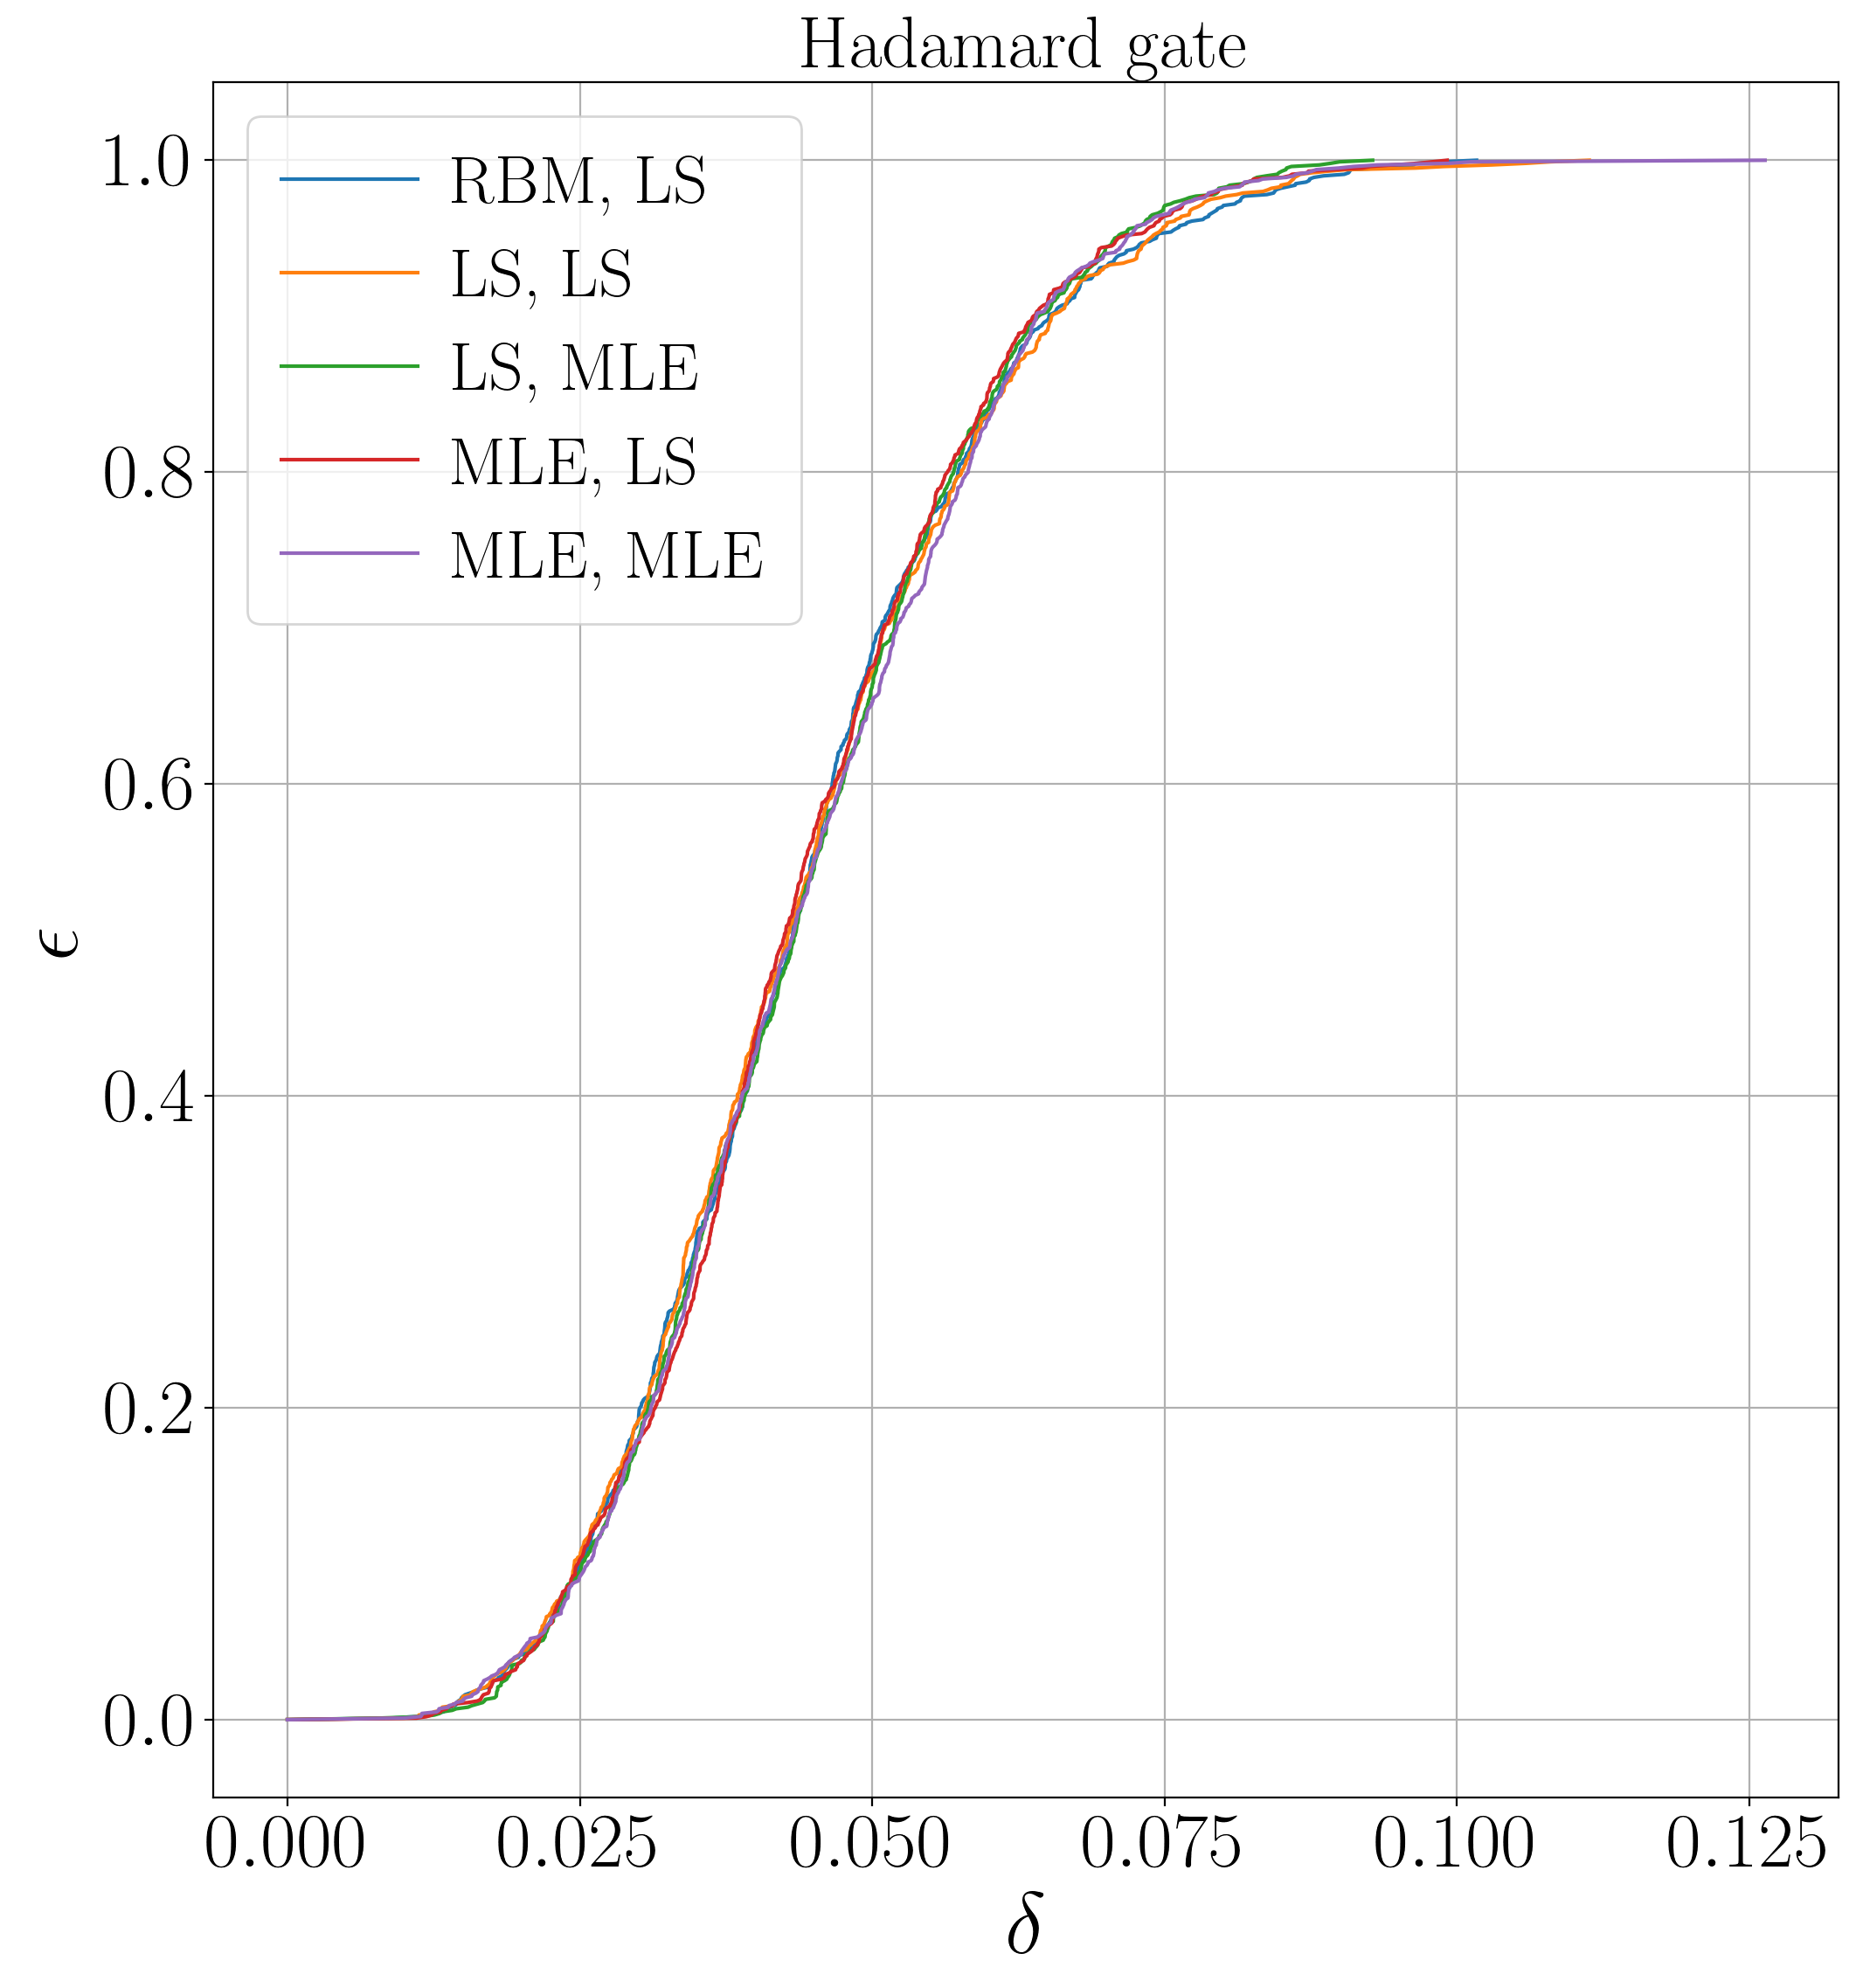

In [86]:
channel = qp.operator.H.as_channel()
name = 'hadamard'
plot_ci_channel(channel, name, 0)

/home/esthete/Dropbox/RQC/pgptomography/Lib/Mixed_multimodel_exaustive.py:193: RuntimeWarning: invalid value encountered in multiply
  state = ampl*np.exp(1j*phase/2.)
/home/esthete/Dropbox/RQC/pgptomography/Lib/Mixed_multimodel_exaustive.py:193: RuntimeWarning: invalid value encountered in true_divide
  state = ampl*np.exp(1j*phase/2.)
/home/esthete/Dropbox/RQC/pgptomography/Lib/quantpy/quantpy/routines.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  diag_vector = tril_matrix[np.diag_indices(tril_matrix.shape[0])].astype(float)


dsfs
sdfsd
asdas


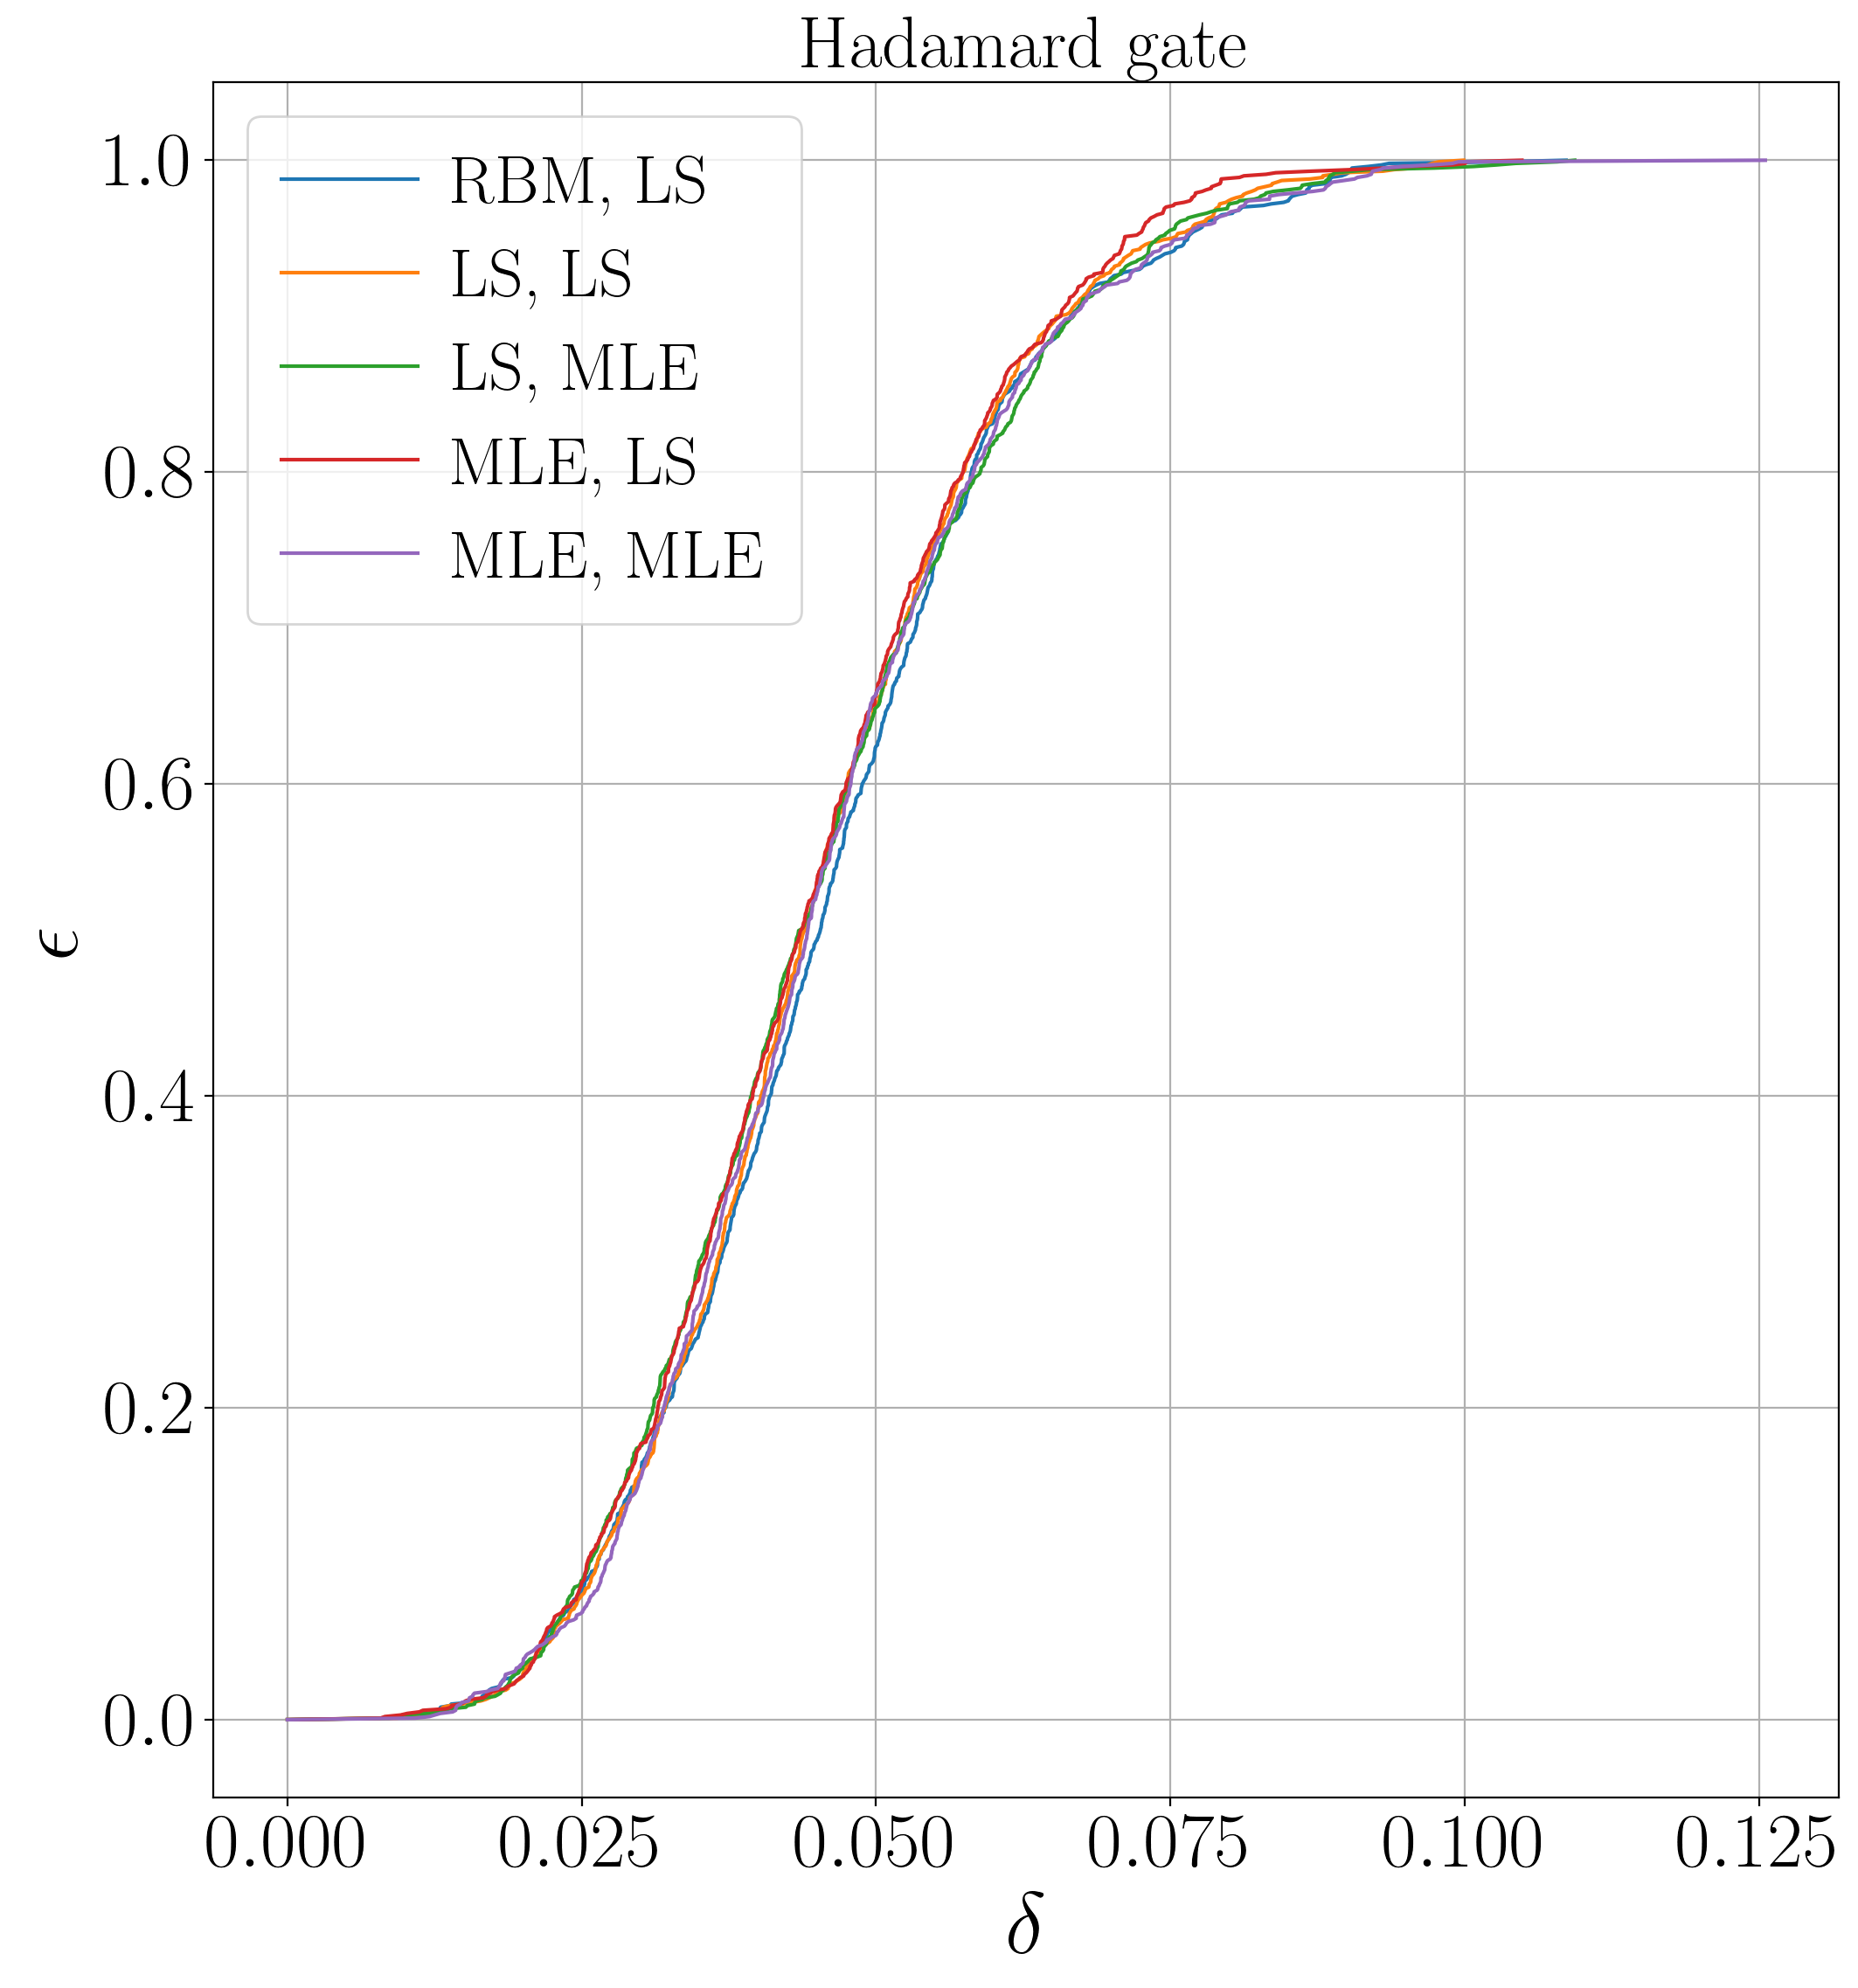

In [87]:
channel = qp.operator.H.as_channel()
name = 'hadamard'
plot_ci_channel(channel, name, 0.01)

dsfs
sdfsd
asdas


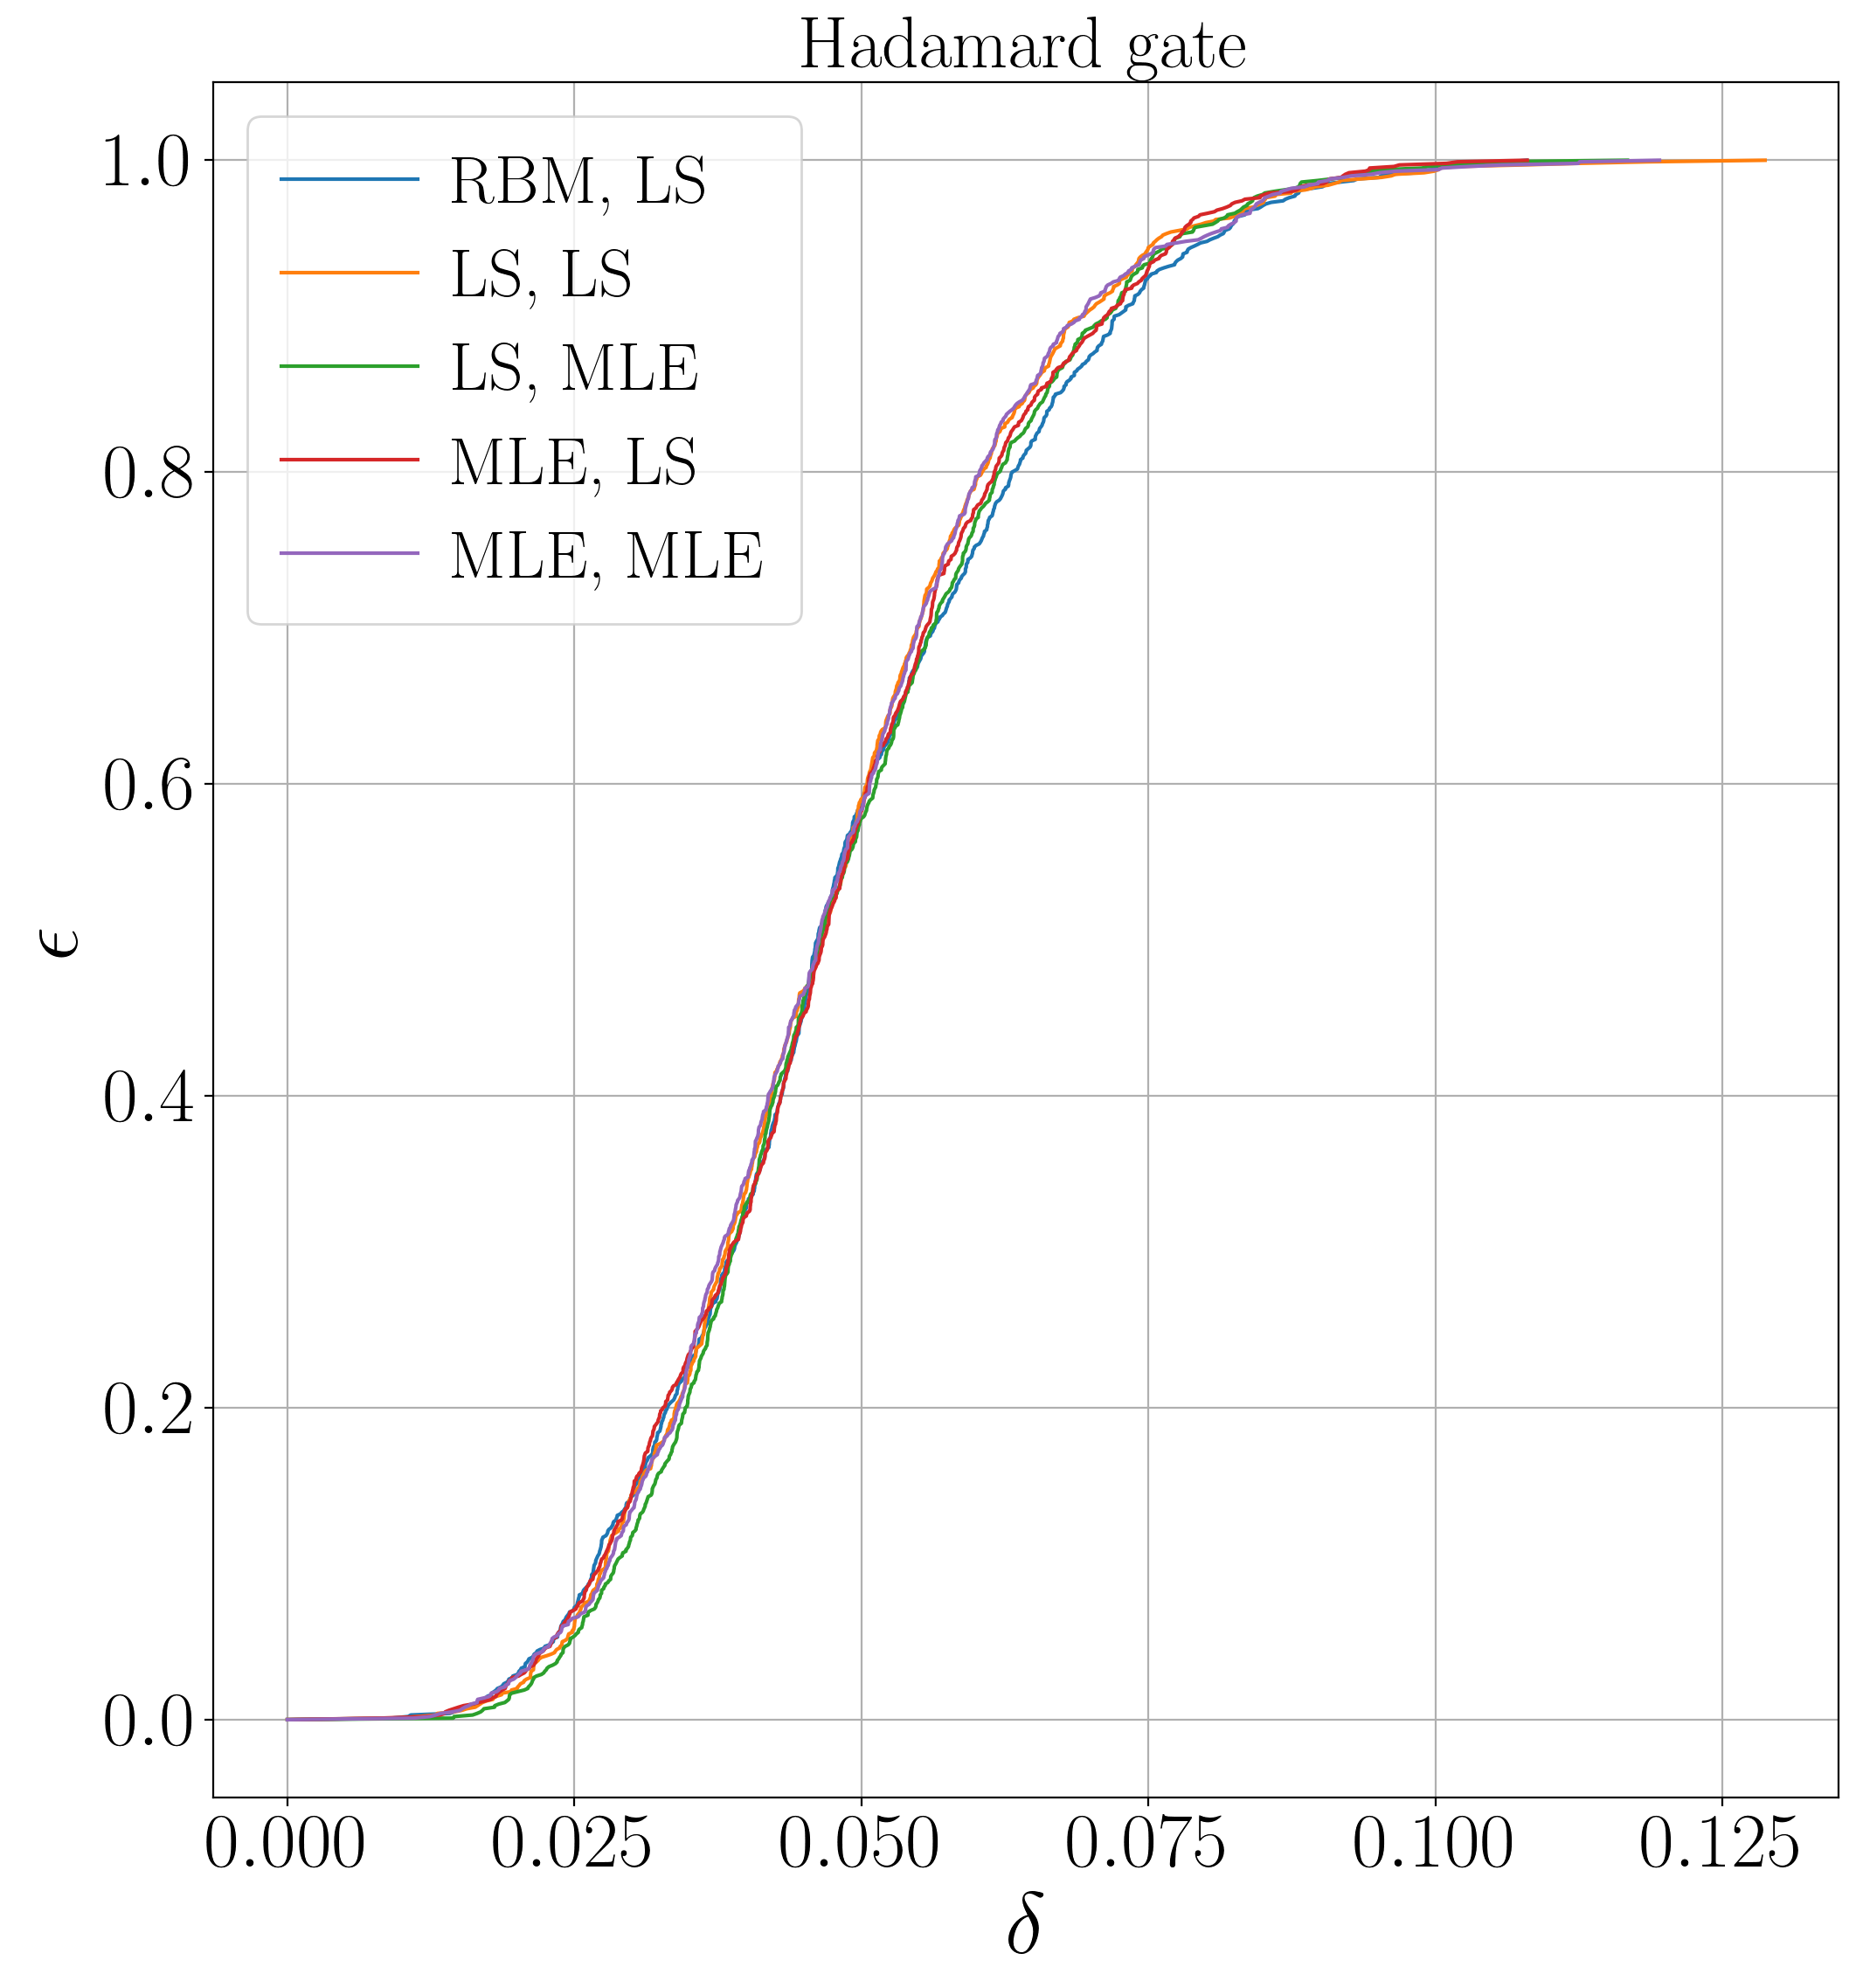

In [88]:
channel = qp.operator.H.as_channel()
name = 'hadamard'
plot_ci_channel(channel, name, 0.05)

dsfs
sdfsd
asdas


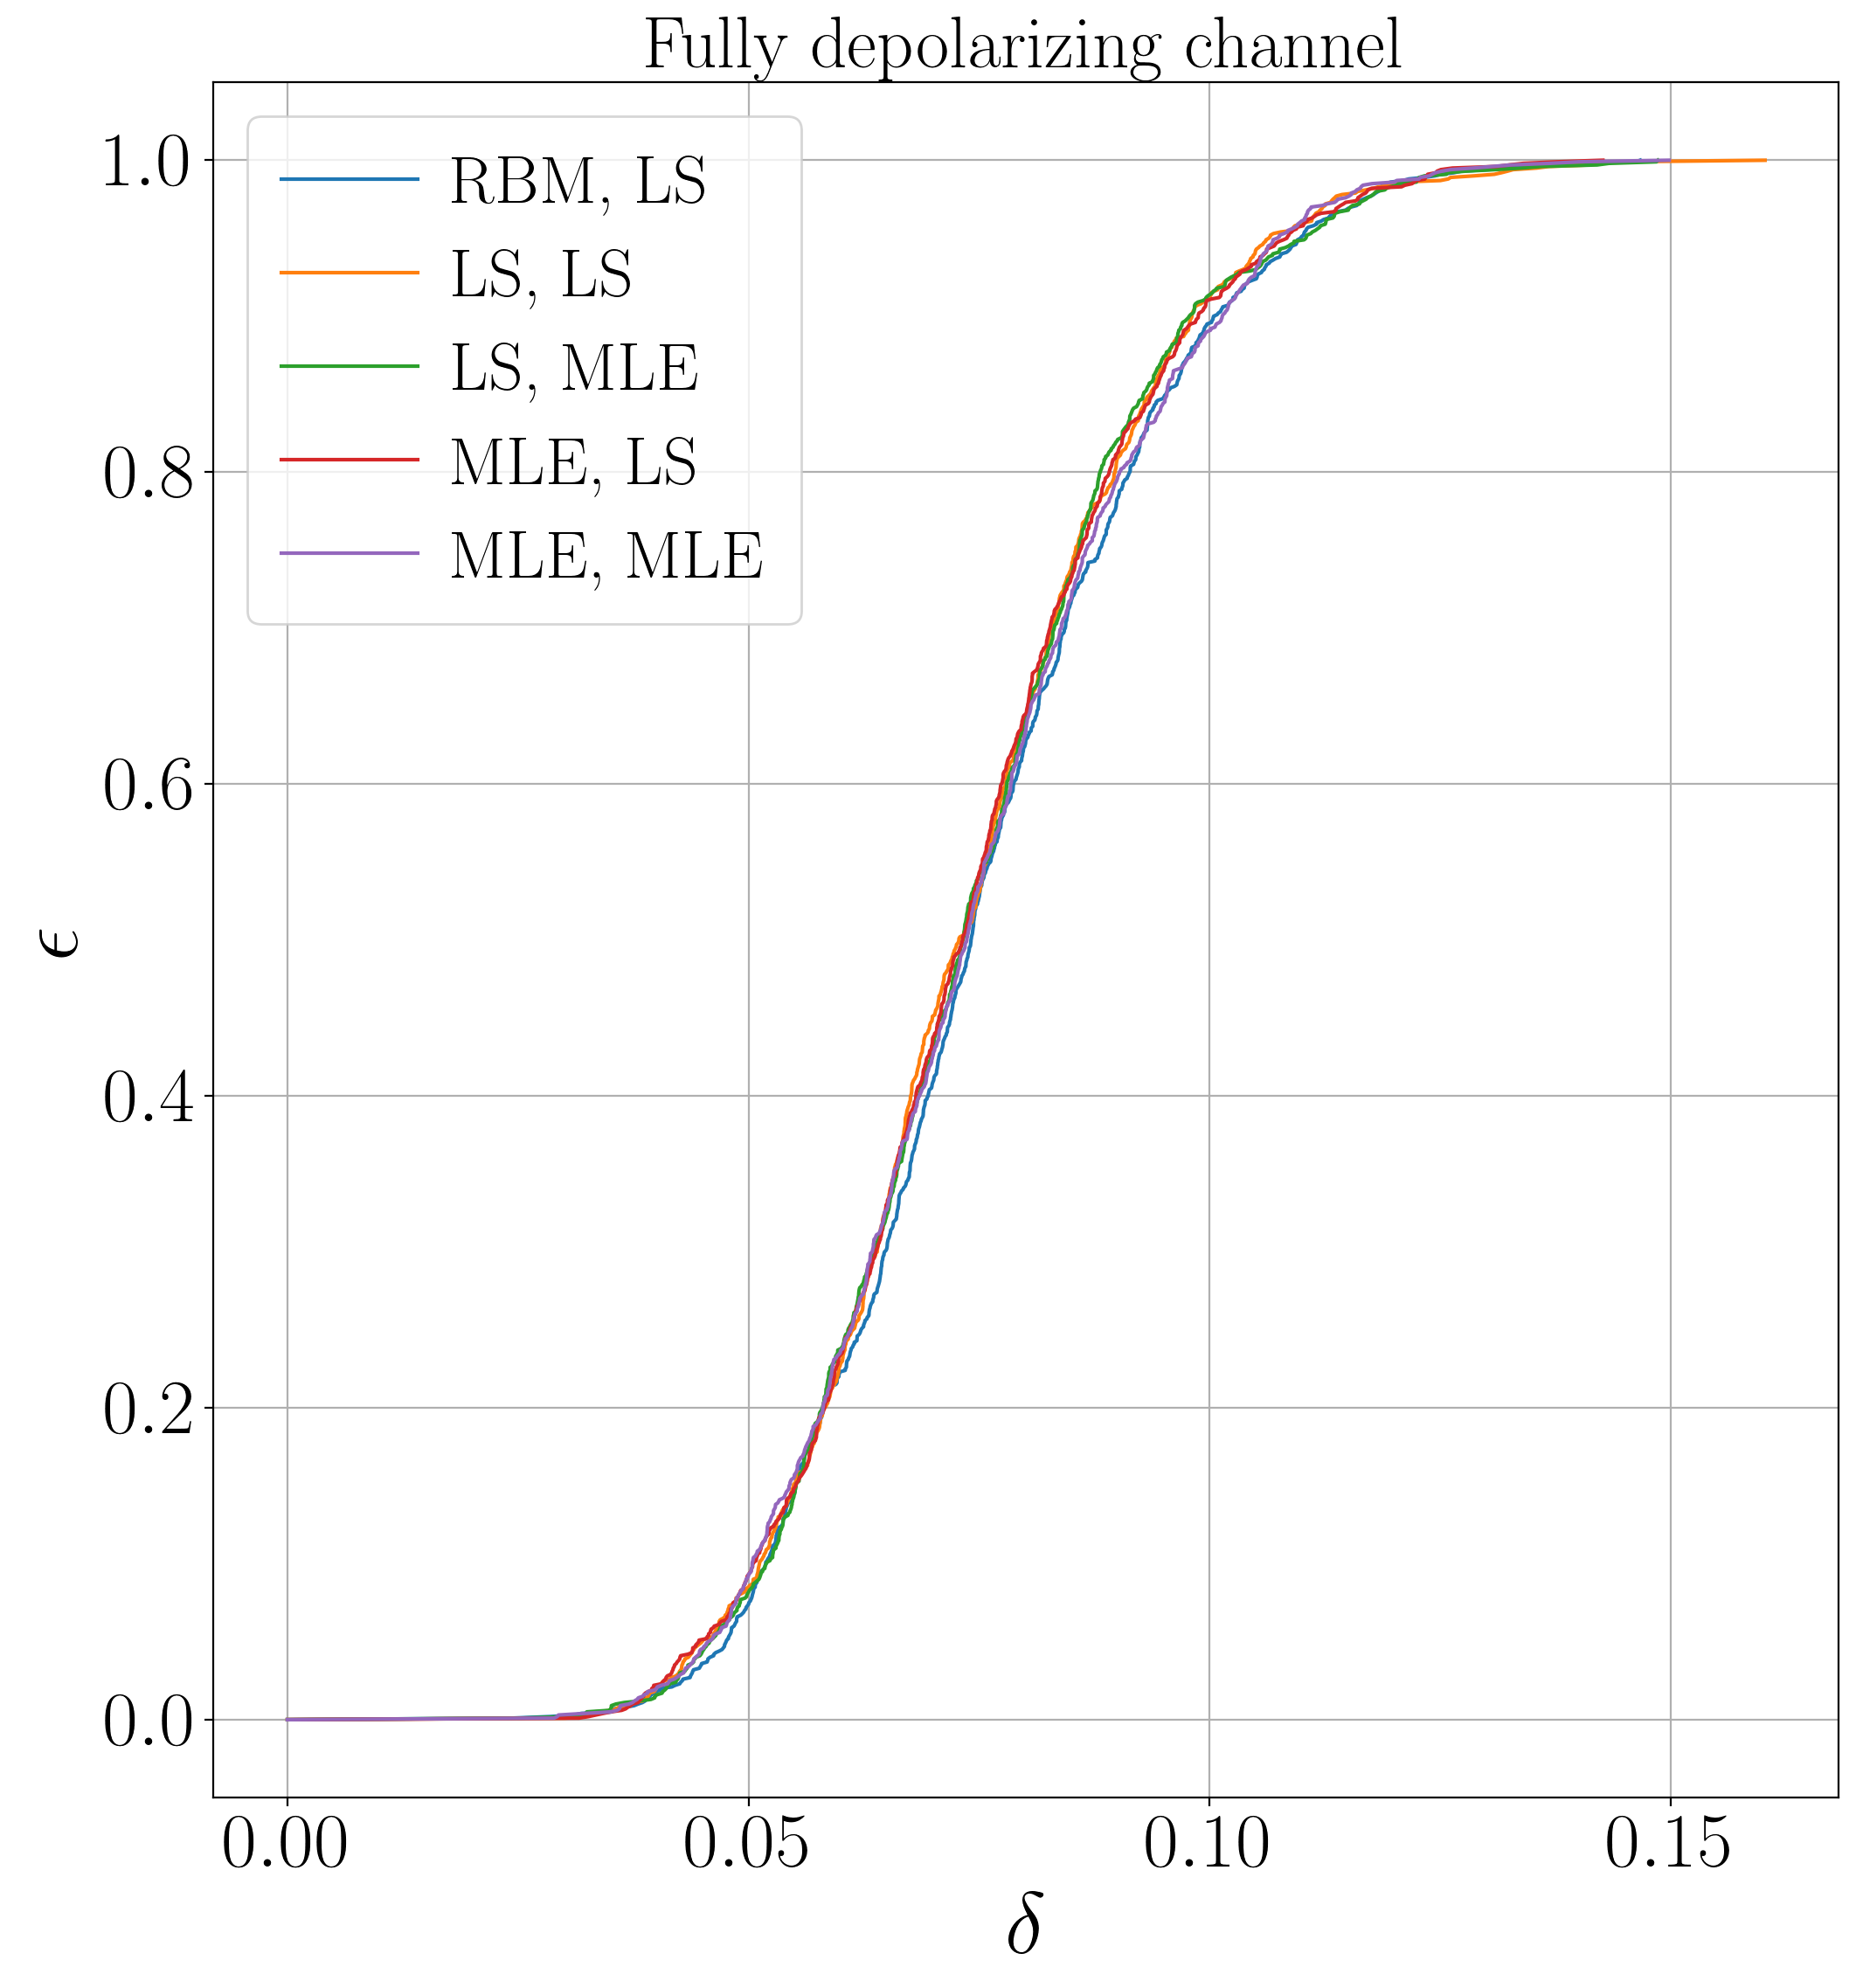

In [89]:
channel = qp.channel.depolarizing(p=1)
name = 'fully-dep'
plot_ci_channel(channel, name, 0)

In [25]:
np.save('hadamard_rbm_n_iter=100_p=0.01.npy', CL_list)

In [15]:
# TODO

channel = qp.channel.depolarizing(p=1)
CL_list = get_CL_list_channel(channel, input_impurity=0.01)
CL_list = np.array(sorted(CL_list))

/home/esthete/Dropbox/RQC/pgptomography/Lib/Mixed_multimodel_exaustive.py:193: RuntimeWarning: invalid value encountered in multiply
  state = ampl*np.exp(1j*phase/2.)
/home/esthete/Dropbox/RQC/pgptomography/Lib/Mixed_multimodel_exaustive.py:193: RuntimeWarning: invalid value encountered in true_divide
  state = ampl*np.exp(1j*phase/2.)


In [16]:
np.save('fullydep_rbm_n_iter=100_p=0.01.npy', CL_list)

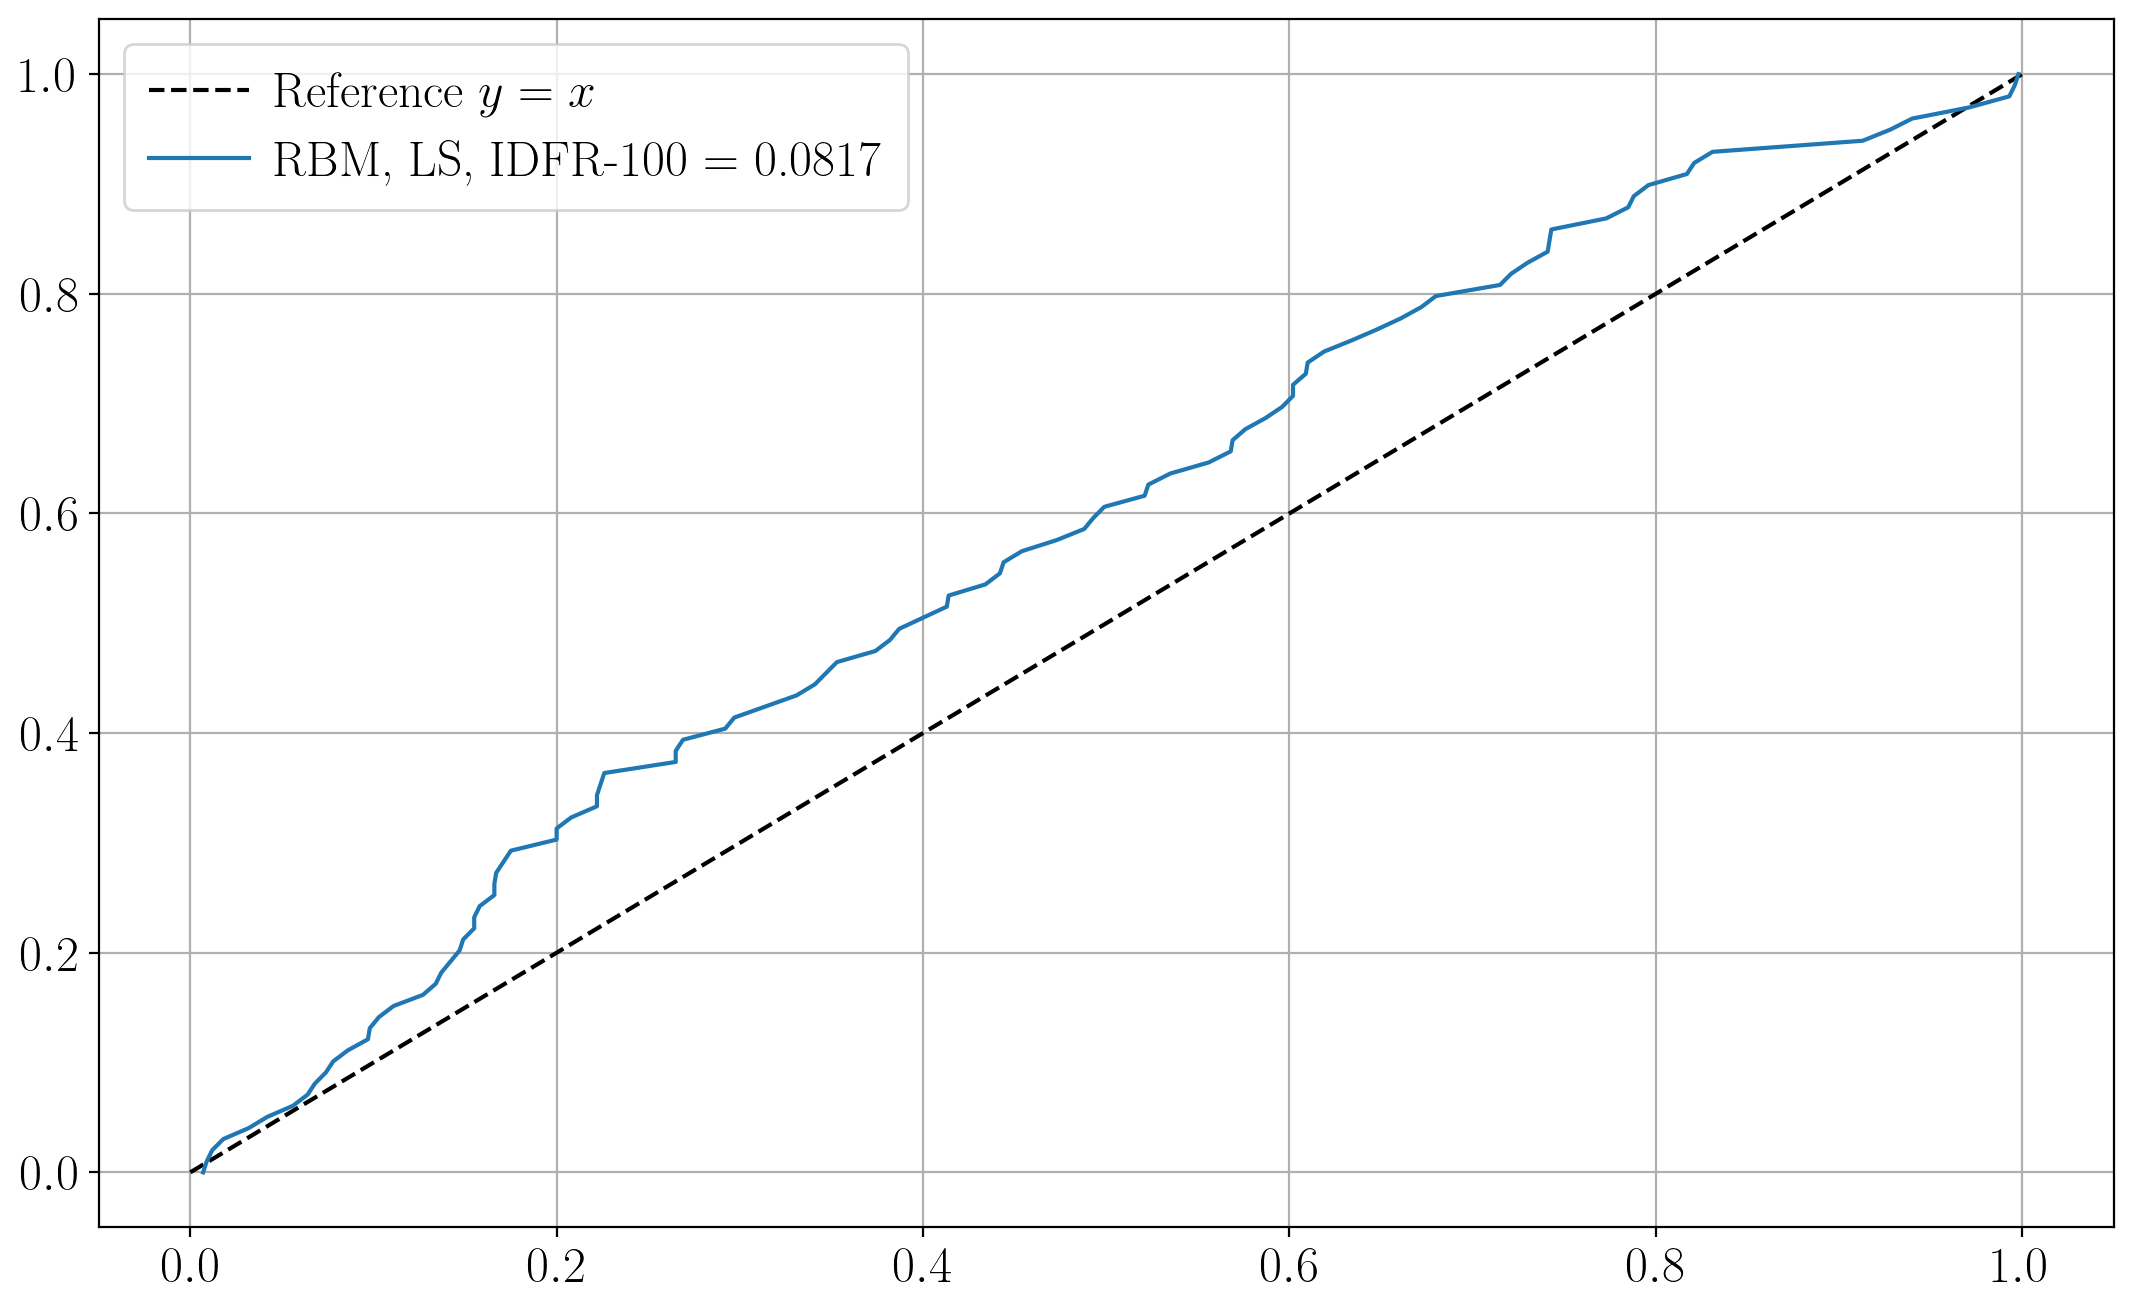

In [17]:
n_iter = 100
n_boot = 10 ** 3

plt.figure(dpi=200, figsize=(13, 8))
plt.grid()
plt.plot(np.linspace(0, 1, n_iter + 1), np.linspace(0, 1, n_iter + 1), '--k', label='Reference $y=x$')
plt.plot(CL_list, np.linspace(0, 1, n_iter), label='RBM, LS, IDFR-{} = {:.4f}'.format(n_iter, count_idfr(CL_list)) )
plt.legend()
plt.show()

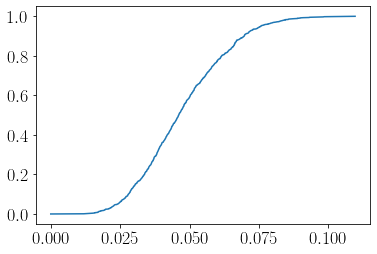

In [19]:
plt.plot(dist_rbm, np.linspace(0, 1, len(dist_rbm)))

In [44]:
channel = qp.operator.H.as_channel()
dist_rbm = get_CL_list_channel(channel, method='rbm')
np.save('rbm_hadamard_1k.npy', dist_rbm)

KeyboardInterrupt: 

## Rubbish

In [61]:
ket = ([0] * 7 + [1, 0, 0, 0, 1, 0, 1, 1, 0]) / np.sqrt(4)
true_rho = qp.Qobj(ket, is_ket=True)
true_rho

Quantum object
array([[0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.

In [60]:
rho

Quantum object
array([[ 3.53209852e-04+0.00000000e+00j,  9.88165806e-05+6.10272465e-04j,
        -4.62323180e-04-3.74962438e-04j, -5.27912384e-04-1.19118646e-04j,
         1.05810111e-04-1.02884301e-04j, -4.78958834e-04-2.76085116e-04j,
         3.78052388e-04+7.45787771e-04j,  5.30969159e-04-1.58662160e-03j,
        -1.85979938e-05+2.23863905e-04j, -3.70422078e-04-3.44211387e-04j,
        -3.94787616e-04-1.77550330e-04j,  1.97264395e-04-8.19355610e-04j,
        -4.63615540e-04+3.50047754e-04j,  1.73421817e-04-1.36233407e-03j,
         8.93931297e-04-6.94020226e-04j, -1.05387137e-05+6.14143860e-05j],
       [ 9.88165806e-05-6.10272465e-04j,  2.14755121e-03+0.00000000e+00j,
        -1.12895187e-03+1.53163089e-03j, -4.53582791e-04+9.69815961e-04j,
        -2.03204284e-04-8.68993853e-04j, -6.36800814e-04+5.33915586e-04j,
         1.19313381e-03-1.27846529e-03j, -6.07516378e-03-6.20589237e-04j,
         7.05915308e-04+3.98686436e-04j, -6.86946778e-04+6.38385067e-04j,
        -6.94883634e-0

In [100]:
qp.measurements.generate_measurement_matrix('proj', 4).shape

(1, 1296, 256)

In [95]:
res = convert_rbm_to_qp(torch.Tensor(results[2]))

4


In [65]:
def compare_methods(state, n_iter=10, n_samples=10000, use=['mle', 'rbm'], verbose=False):    
    distances = defaultdict(list)
    times = defaultdict(list)
    
    rbm_results = torch.zeros(3, 6 ** state.n_qubits)
    for i in range(6 ** state.n_qubits):
        rbm_results[0, i] = i // (2 ** state.n_qubits)
        rbm_results[1, i] = i % (2 ** state.n_qubits)
    
    cycle = tqdm(range(n_iter)) if verbose else range(n_iter)
    for _ in cycle:
        tmg = qp.tomography.StateTomograph(state)
        tmg.experiment(n_samples)
        
        t = time.time()
        rho_lin = tmg.point_estimate()
        times['Linear'].append(time.time() - t)
        
        if 'mle' in use:
            t = time.time()
            rho_mle = tmg.point_estimate('mle')
            times['MLE'].append(time.time() - t)
            
        if 'rbm' in use:
#             rbm_results[2] = convert_qp_to_rbm(tmg.results / n_samples * 3 ** state.n_qubits)
#             return rbm_results
            rbm_results[2] = tmg.results
            loopmodel_num = 1
            model_num = 50
            dimV = 2 * state.n_qubits
            N_qubits = state.n_qubits
            dimH = 30
            N_epochs = 1000
            batch_size = rbm_results.shape[1]
            learning_rate = 10
            sigma = 3
            alpha = 0.99
            N_samples = 1000
            N_steps = 20
            device = 'cpu'
            indexes=torch.arange(4 ** state.n_qubits, dtype=torch.int32)

            t = time.time()
            f_proj = f(rbm_results,indexes,dimV,datatype,device)
            rho_rbm_raw, _, _, loss_func = rbm(rbm_results,loopmodel_num,model_num,dimV,dimH,N_epochs,batch_size,
                                               learning_rate,sigma,alpha,N_samples,N_steps,device,datatype,
                                               indexes,f_proj)

            min_ind = np.unravel_index(np.nanargmin(loss_func[:,:,-1]),(loopmodel_num,model_num))
            rho_rbm = rho_rbm_raw[min_ind[0]][min_ind[1]]
            times['RBM'].append(time.time() - t)
        
        distances['Linear'].append(qp.hs_dst(state, rho_lin))
        if 'mle' in use:
            distances['MLE'].append(qp.hs_dst(state, rho_mle))
        if 'rbm' in use:
            distances['RBM'].append(qp.hs_dst(state, rho_rbm))
        
    return distances, times

In [66]:
def build_plot(results, n_samples_list, dpi=200, figsize=(13, 7), save=True, path=None, 
               xlabel='Number of samples', ylabel='HS', title=''):
    plt.figure(figsize=figsize, dpi=dpi)
    plt.grid()
    for key, res in results.items():
        plt.plot(n_samples_list[:len(res)], res, label=key)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    if save:
        plt.savefig(path)
    plt.show()

# GHZ Egor

In [67]:
rbm_res = np.loadtxt('measurements.dat')
rbm_res

array([[0.        , 0.        , 0.        , 0.        , 1.        ,
        1.        , 1.        , 1.        , 2.        , 2.        ,
        2.        , 2.        , 3.        , 3.        , 3.        ,
        3.        , 4.        , 4.        , 4.        , 4.        ,
        5.        , 5.        , 5.        , 5.        , 6.        ,
        6.        , 6.        , 6.        , 7.        , 7.        ,
        7.        , 7.        , 8.        , 8.        , 8.        ,
        8.        ],
       [0.        , 1.        , 2.        , 3.        , 0.        ,
        1.        , 2.        , 3.        , 0.        , 1.        ,
        2.        , 3.        , 0.        , 1.        , 2.        ,
        3.        , 0.        , 1.        , 2.        , 3.        ,
        0.        , 1.        , 2.        , 3.        , 0.        ,
        1.        , 2.        , 3.        , 0.        , 1.        ,
        2.        , 3.        , 0.        , 1.        , 2.        ,
        3.        ],
      

In [69]:
convert_rbm_to_qp(torch.Tensor(rbm_res))

tensor([[0.2466, 0.2536, 0.2502, 0.2563, 0.4945, 0.0000, 0.0000, 0.5020, 0.2544,
         0.2512, 0.2445, 0.2485, 0.4939, 0.0000, 0.0000, 0.5040, 0.2479, 0.2497,
         0.2439, 0.2486, 0.2516, 0.2561, 0.2576, 0.2539, 0.2495, 0.2420, 0.2536,
         0.2536, 0.2479, 0.2577, 0.2351, 0.2453, 0.5022, 0.0000, 0.0000, 0.4951],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

# iGHZ state, n=2

In [70]:
ket = [1, 0, 0, 1j] / np.sqrt(2)
rho = qp.Qobj(data=ket, is_ket=True)
rho

Quantum object
array([[0.5+0.j , 0. +0.j , 0. +0.j , 0. -0.5j],
       [0. +0.j , 0. +0.j , 0. +0.j , 0. +0.j ],
       [0. +0.j , 0. +0.j , 0. +0.j , 0. +0.j ],
       [0. +0.5j, 0. +0.j , 0. +0.j , 0.5+0.j ]])

In [72]:
lin_acc = []
mle_acc = []
rbm_acc = []

n_samples_list = np.logspace(2, 6, 15)
for n_samples in n_samples_list:
    dist_lin, dist_mle = compare_methods(rho, n_iter=1, n_samples=int(n_samples), use=['mle'])
    lin_acc.append(np.mean(dist_lin))
    mle_acc.append(np.mean(dist_mle))
#     rbm_acc.append(np.mean(dist_rbm))

TypeError: unsupported operand type(s) for /: 'collections.defaultdict' and 'int'

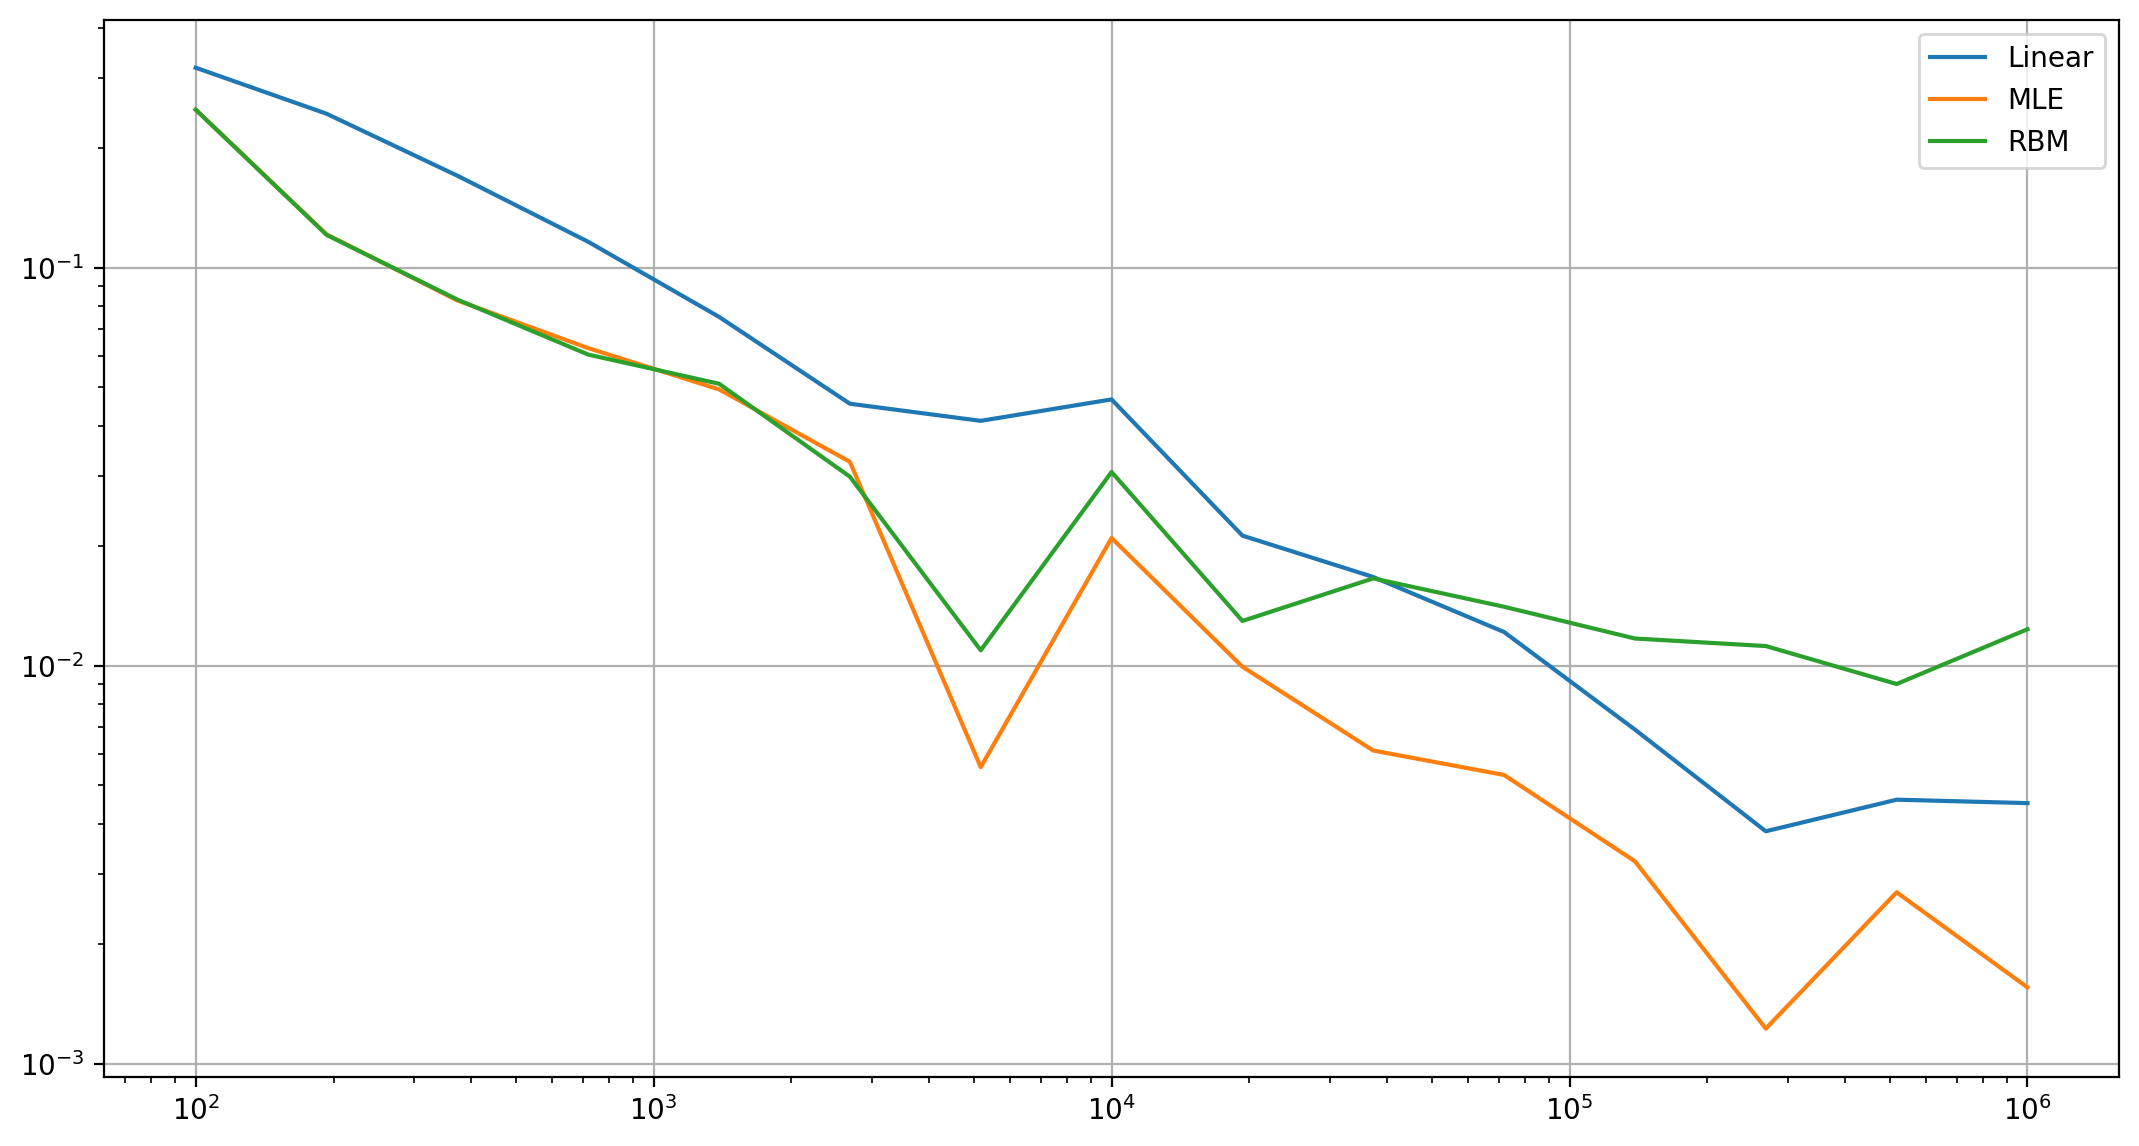

In [12]:
plt.figure(figsize=(13, 7), dpi=200)
plt.grid()
plt.plot(n_samples_list[:len(lin_acc)], lin_acc, label='Linear')
plt.plot(n_samples_list[:len(lin_acc)], mle_acc, label='MLE')
plt.plot(n_samples_list[:len(lin_acc)], rbm_acc, label='RBM')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('imgs/rbm_high_1000epochs_new_version.png')
plt.show()

In [331]:
print('Linear:', np.mean(dist_lin))
print('MLE:', np.mean(dist_mle))
print('RBM:', np.mean(dist_rbm))

Linear: 0.25309176515392284
MLE: 0.12893983469728584
RBM: 0.1818142707523971


# GHZ, n=1

In [59]:
rho = get_GHZ(1)

distances = defaultdict(list)
times = defaultdict(list)

n_samples_list = np.logspace(3, 7, 10)
for n_samples in tqdm(n_samples_list):
    distances_sample, times_sample = compare_methods(rho, n_iter=2, n_samples=int(n_samples))
    for key in distances_sample.keys():
        distances[key].append(np.mean(distances_sample[key]))
        times[key].append(np.mean(times_sample[key]))

/home/esthete/Dropbox/RQC/pgptomography/Lib/Mixed_multimodel_exaustive.py:193: RuntimeWarning: invalid value encountered in multiply
  state = ampl*np.exp(1j*phase/2.)
/home/esthete/Dropbox/RQC/pgptomography/Lib/Mixed_multimodel_exaustive.py:193: RuntimeWarning: invalid value encountered in true_divide
  state = ampl*np.exp(1j*phase/2.)


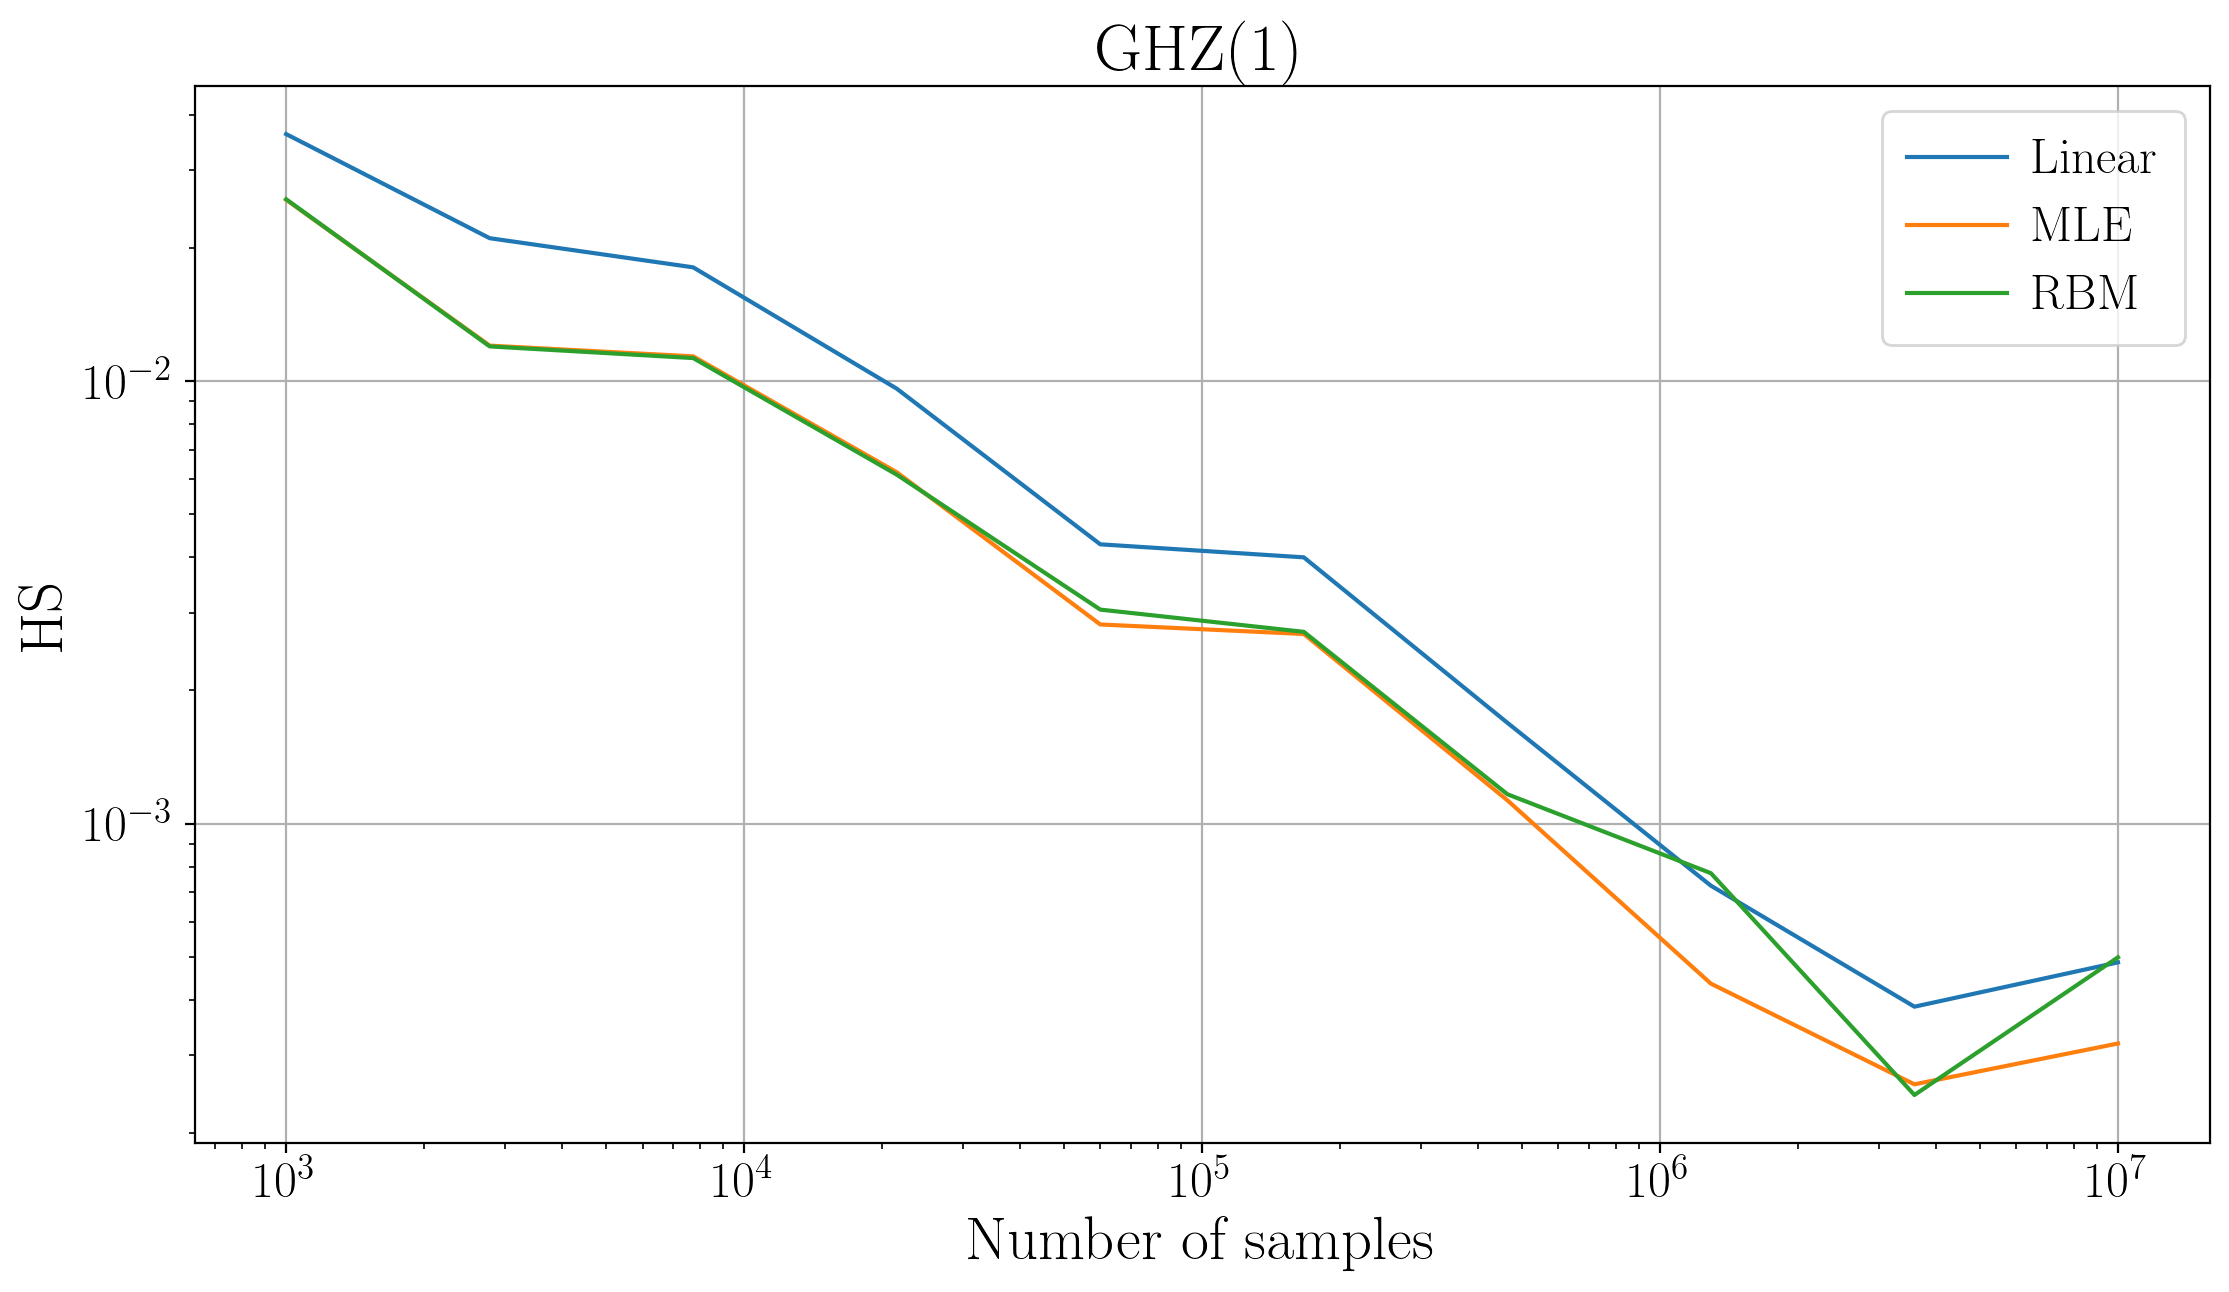

In [67]:
build_plot(distances, n_samples_list, save=True, title='GHZ(1)', path='imgs/rbm/ghz1_dist.png')

# GHZ, n=2

In [70]:
rho = get_GHZ(2)

distances = defaultdict(list)
times = defaultdict(list)

n_samples_list = np.logspace(3, 7, 10)
for n_samples in tqdm(n_samples_list):
    distances_sample, times_sample = compare_methods(rho, n_iter=2, n_samples=int(n_samples))
    for key in distances_sample.keys():
        distances[key].append(np.mean(distances_sample[key]))
        times[key].append(np.mean(times_sample[key]))

/home/esthete/Dropbox/RQC/pgptomography/Lib/quantpy/quantpy/routines.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  diag_vector = tril_matrix[np.diag_indices(tril_matrix.shape[0])].astype(float)
/home/esthete/Dropbox/RQC/pgptomography/Lib/Mixed_multimodel_exaustive.py:193: RuntimeWarning: invalid value encountered in multiply
  state = ampl*np.exp(1j*phase/2.)
/home/esthete/Dropbox/RQC/pgptomography/Lib/Mixed_multimodel_exaustive.py:193: RuntimeWarning: invalid value encountered in true_divide
  state = ampl*np.exp(1j*phase/2.)


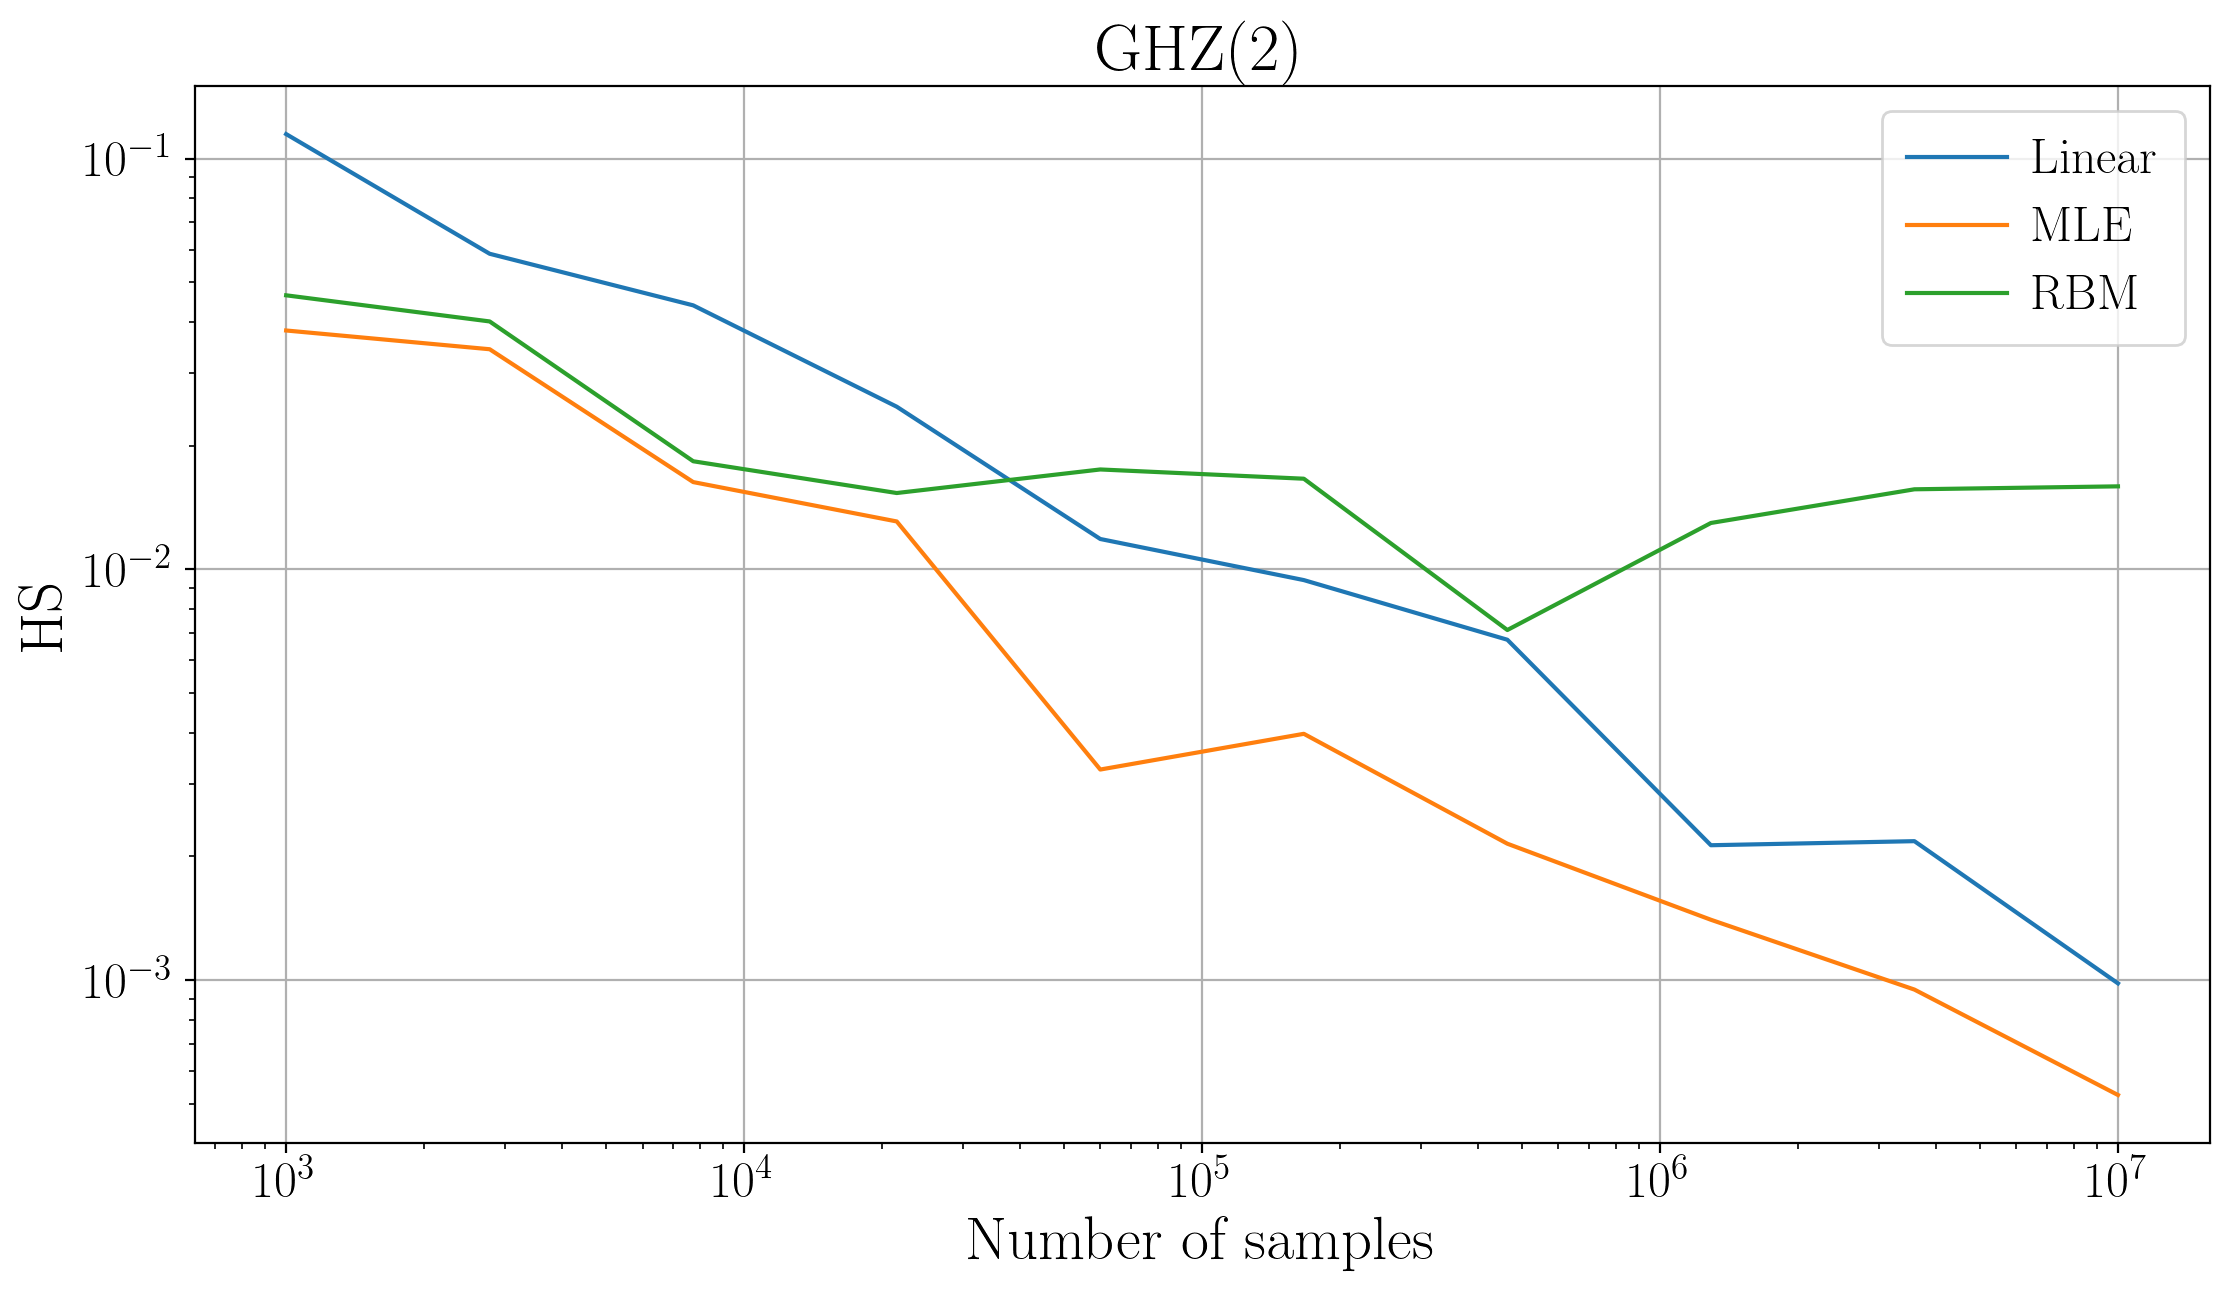

In [71]:
build_plot(distances, n_samples_list, save=True, title='GHZ(2)', path='imgs/rbm/ghz2_dist.png')

# GHZ, n=3

In [43]:
rho = get_GHZ(3)

distances = defaultdict(list)
times = defaultdict(list)

n_samples_list = np.logspace(3, 7, 5)
for n_samples in tqdm(n_samples_list):
    distances_sample, times_sample = compare_methods(rho, n_iter=5, n_samples=int(n_samples), use=['mle'])
    for key in distances_sample.keys():
        distances[key].append(np.mean(distances_sample[key]))
        times[key].append(np.mean(times_sample[key]))

/home/esthete/Dropbox/RQC/pgptomography/Lib/quantpy/quantpy/routines.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  diag_vector = tril_matrix[np.diag_indices(tril_matrix.shape[0])].astype(float)


In [47]:
states = [np.load('Rhos/rho{}.npy'.format(i)) for i in range(3, 8)]
rbm_dist = [qp.hs_dst(state, get_GHZ(3)) for state in states]

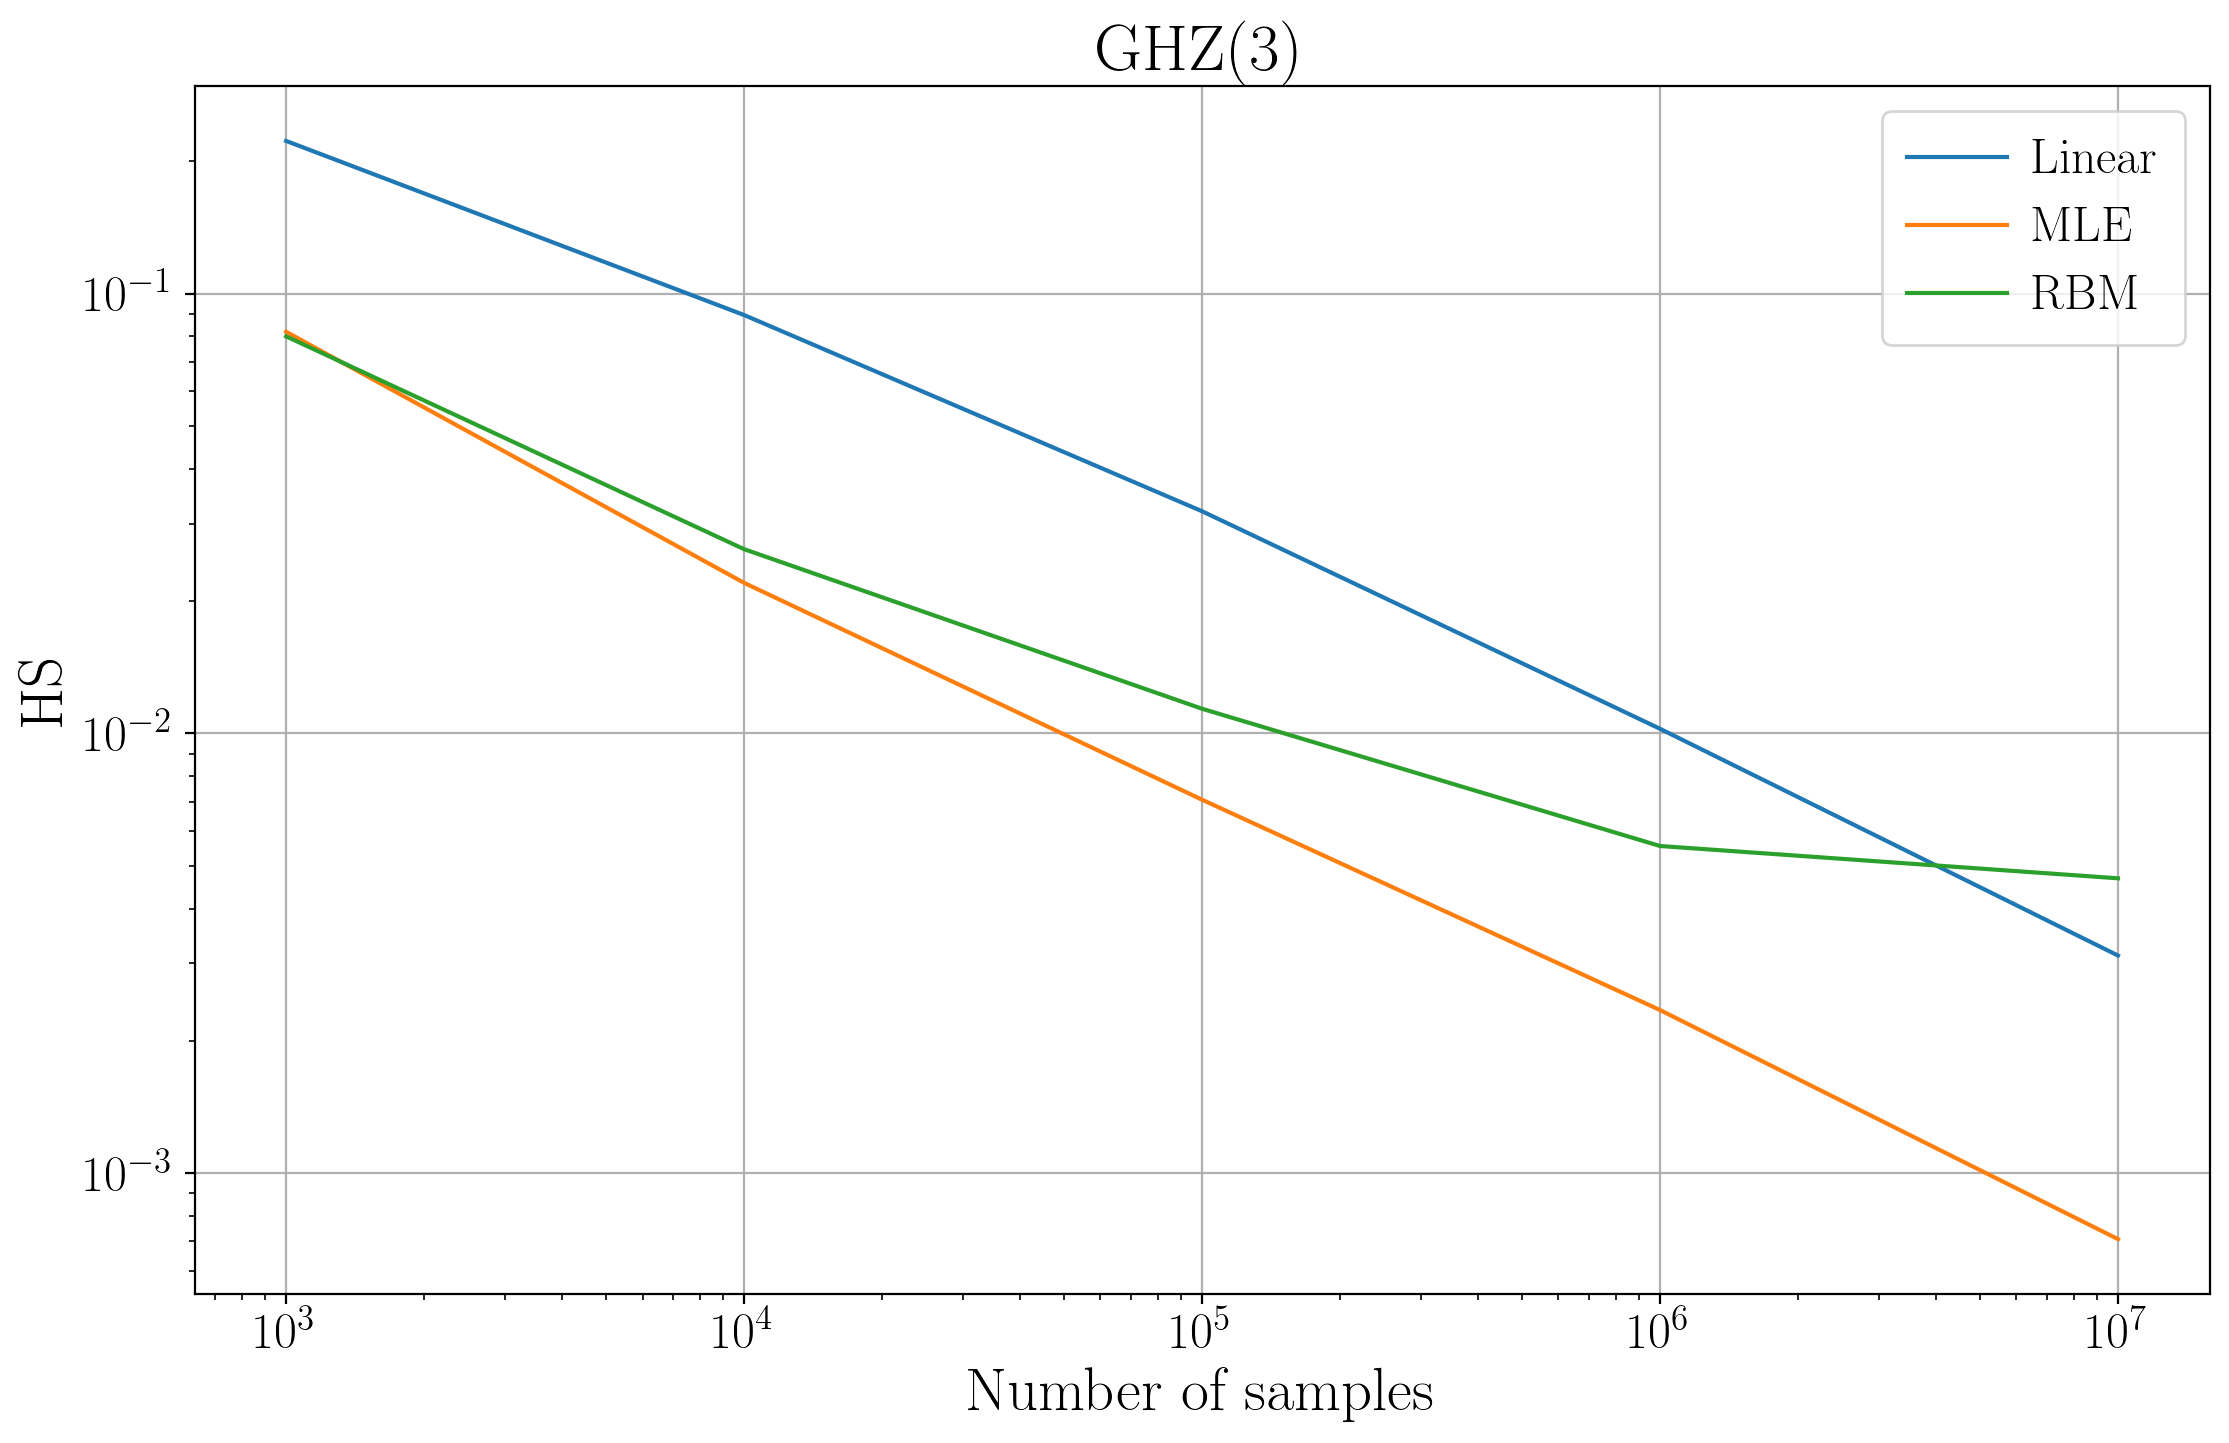

In [49]:
plt.figure(figsize=(13, 8), dpi=200)
plt.grid()
for key, res in distances.items():
    plt.plot(n_samples_list[:len(res)], res, label=key)
plt.plot(n_samples_list, rbm_dist, label='RBM')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of samples')
plt.ylabel('HS')
plt.title('GHZ(3)')
plt.legend()
plt.savefig('imgs/rbm/ghz3_dist_1.png')
plt.show()

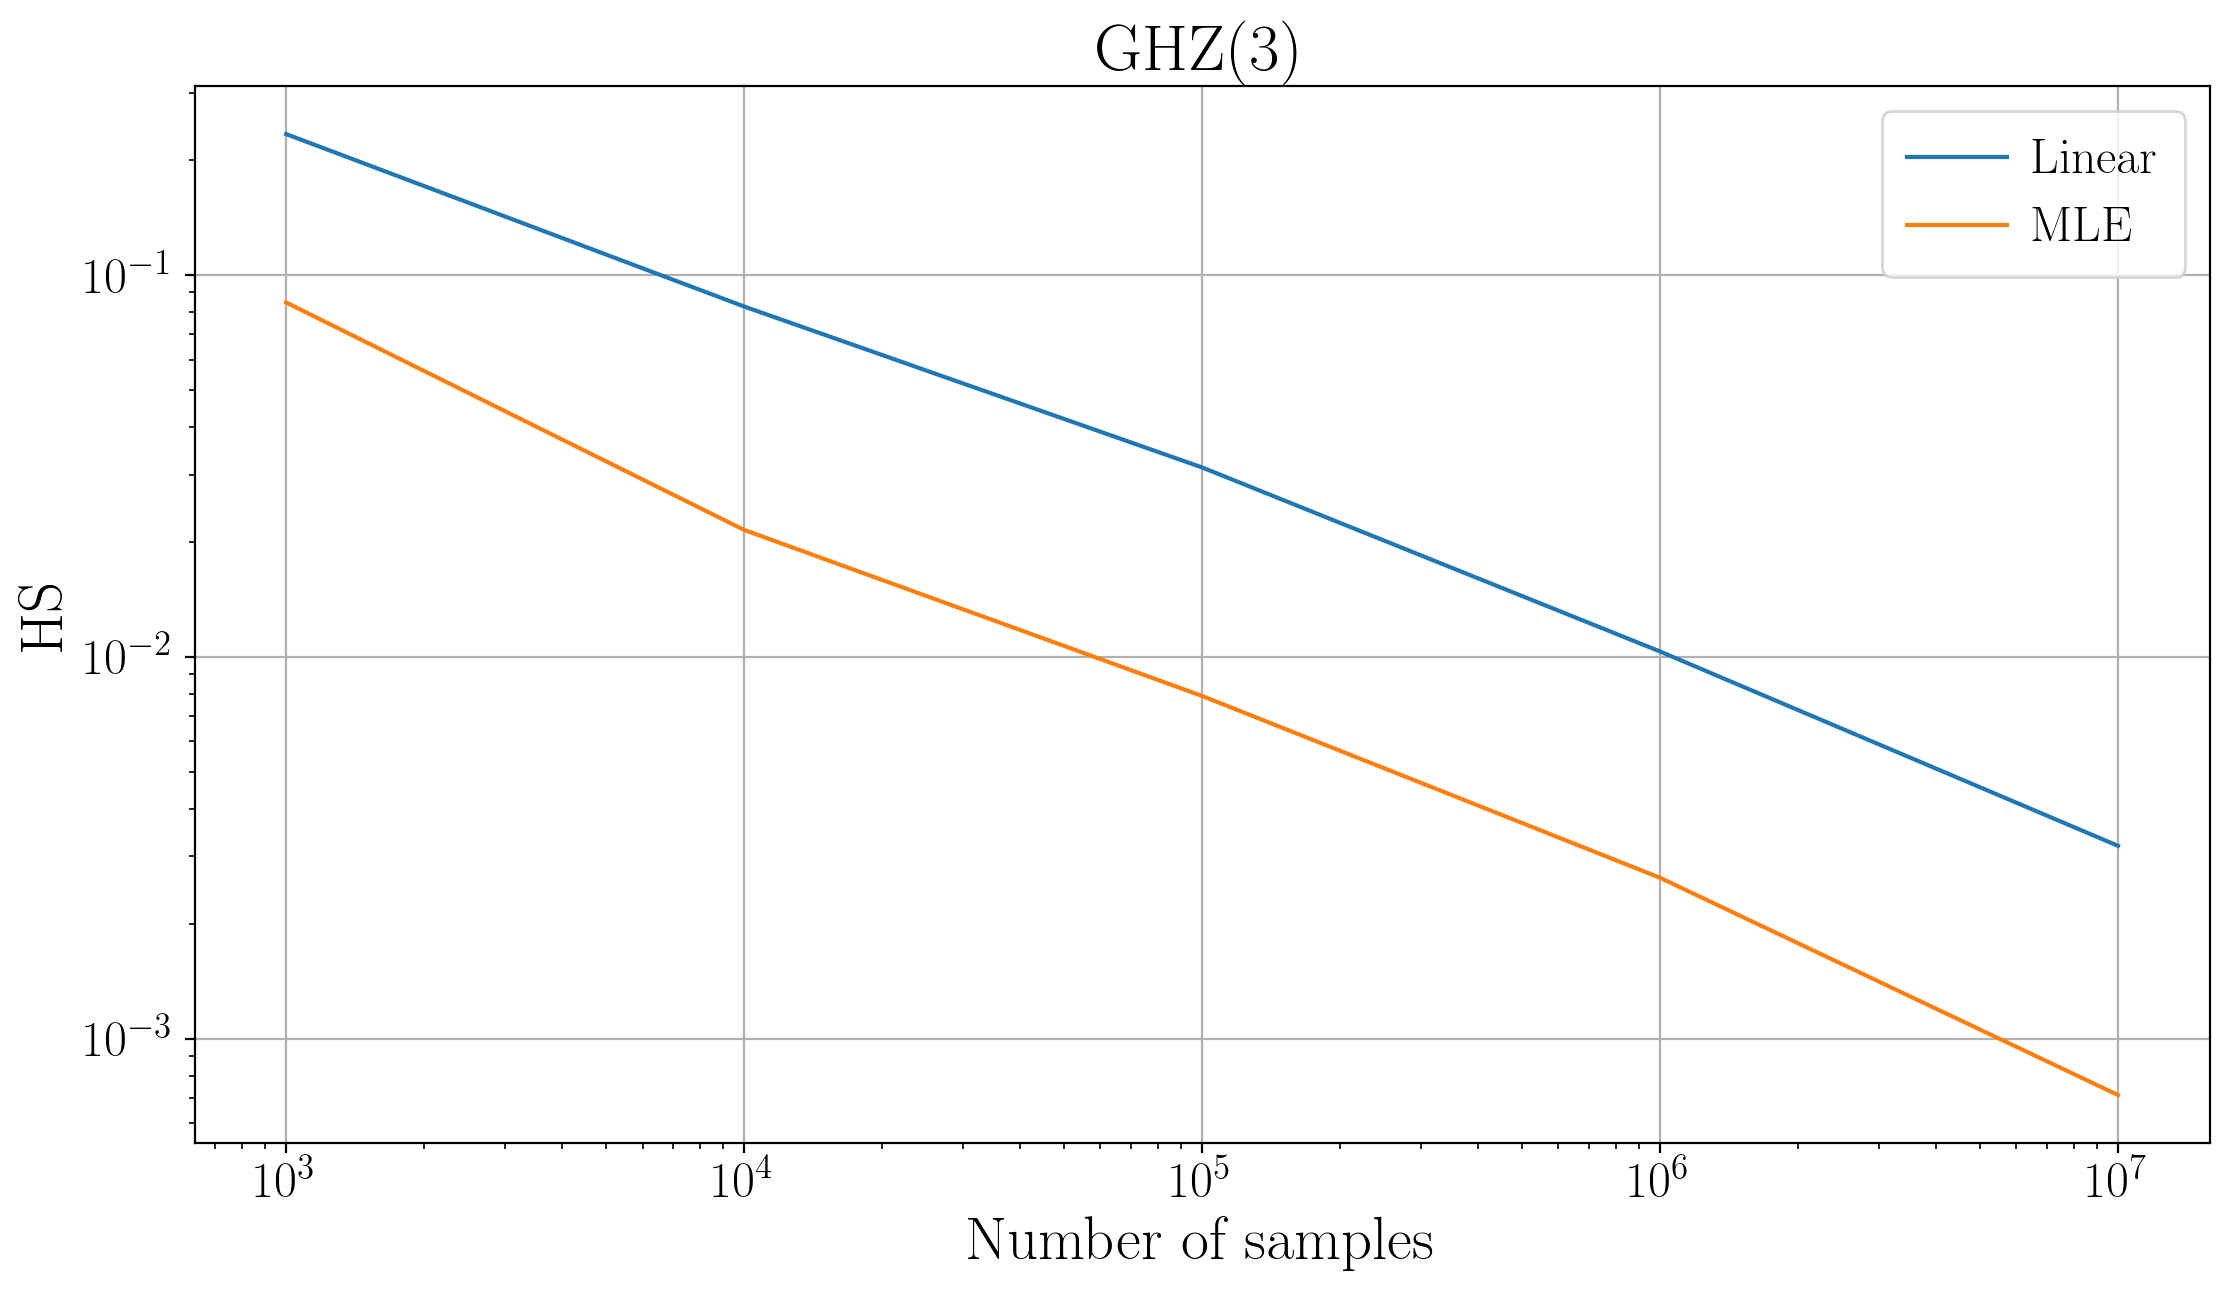

In [36]:
build_plot(distances, n_samples_list, save=True, title='GHZ(3)', path='imgs/rbm/ghz3_dist_1.png')